<a href="https://colab.research.google.com/github/JHyunjun/AnomalyDetection/blob/main/240909_W30_MM_wo80000_EF044.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
# # TensorFlow 버전 출력
# print("TensorFlow 버전:", tf.__version__)

# # 사용 가능한 GPU 목록 확인
# gpus = tf.config.list_physical_devices('GPU')
# print("사용 가능한 GPU:", gpus)

# if gpus:
#     # GPU가 감지되면 간단한 연산 수행
#     with tf.device('/GPU:0'):
#         a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
#         b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
#         c = tf.matmul(a, b)
#         print("GPU에서 수행된 행렬 곱셈 결과:")
#         print(c)
# else:
#     print("GPU를 찾을 수 없습니다. CPU에서 실행됩니다.")

# # 현재 사용 중인 장치 확인
# print("현재 사용 중인 장치:", tf.test.gpu_device_name())

# # GPU 사용 가능 여부 확인
# print("GPU 사용 가능:", tf.test.is_built_with_cuda())

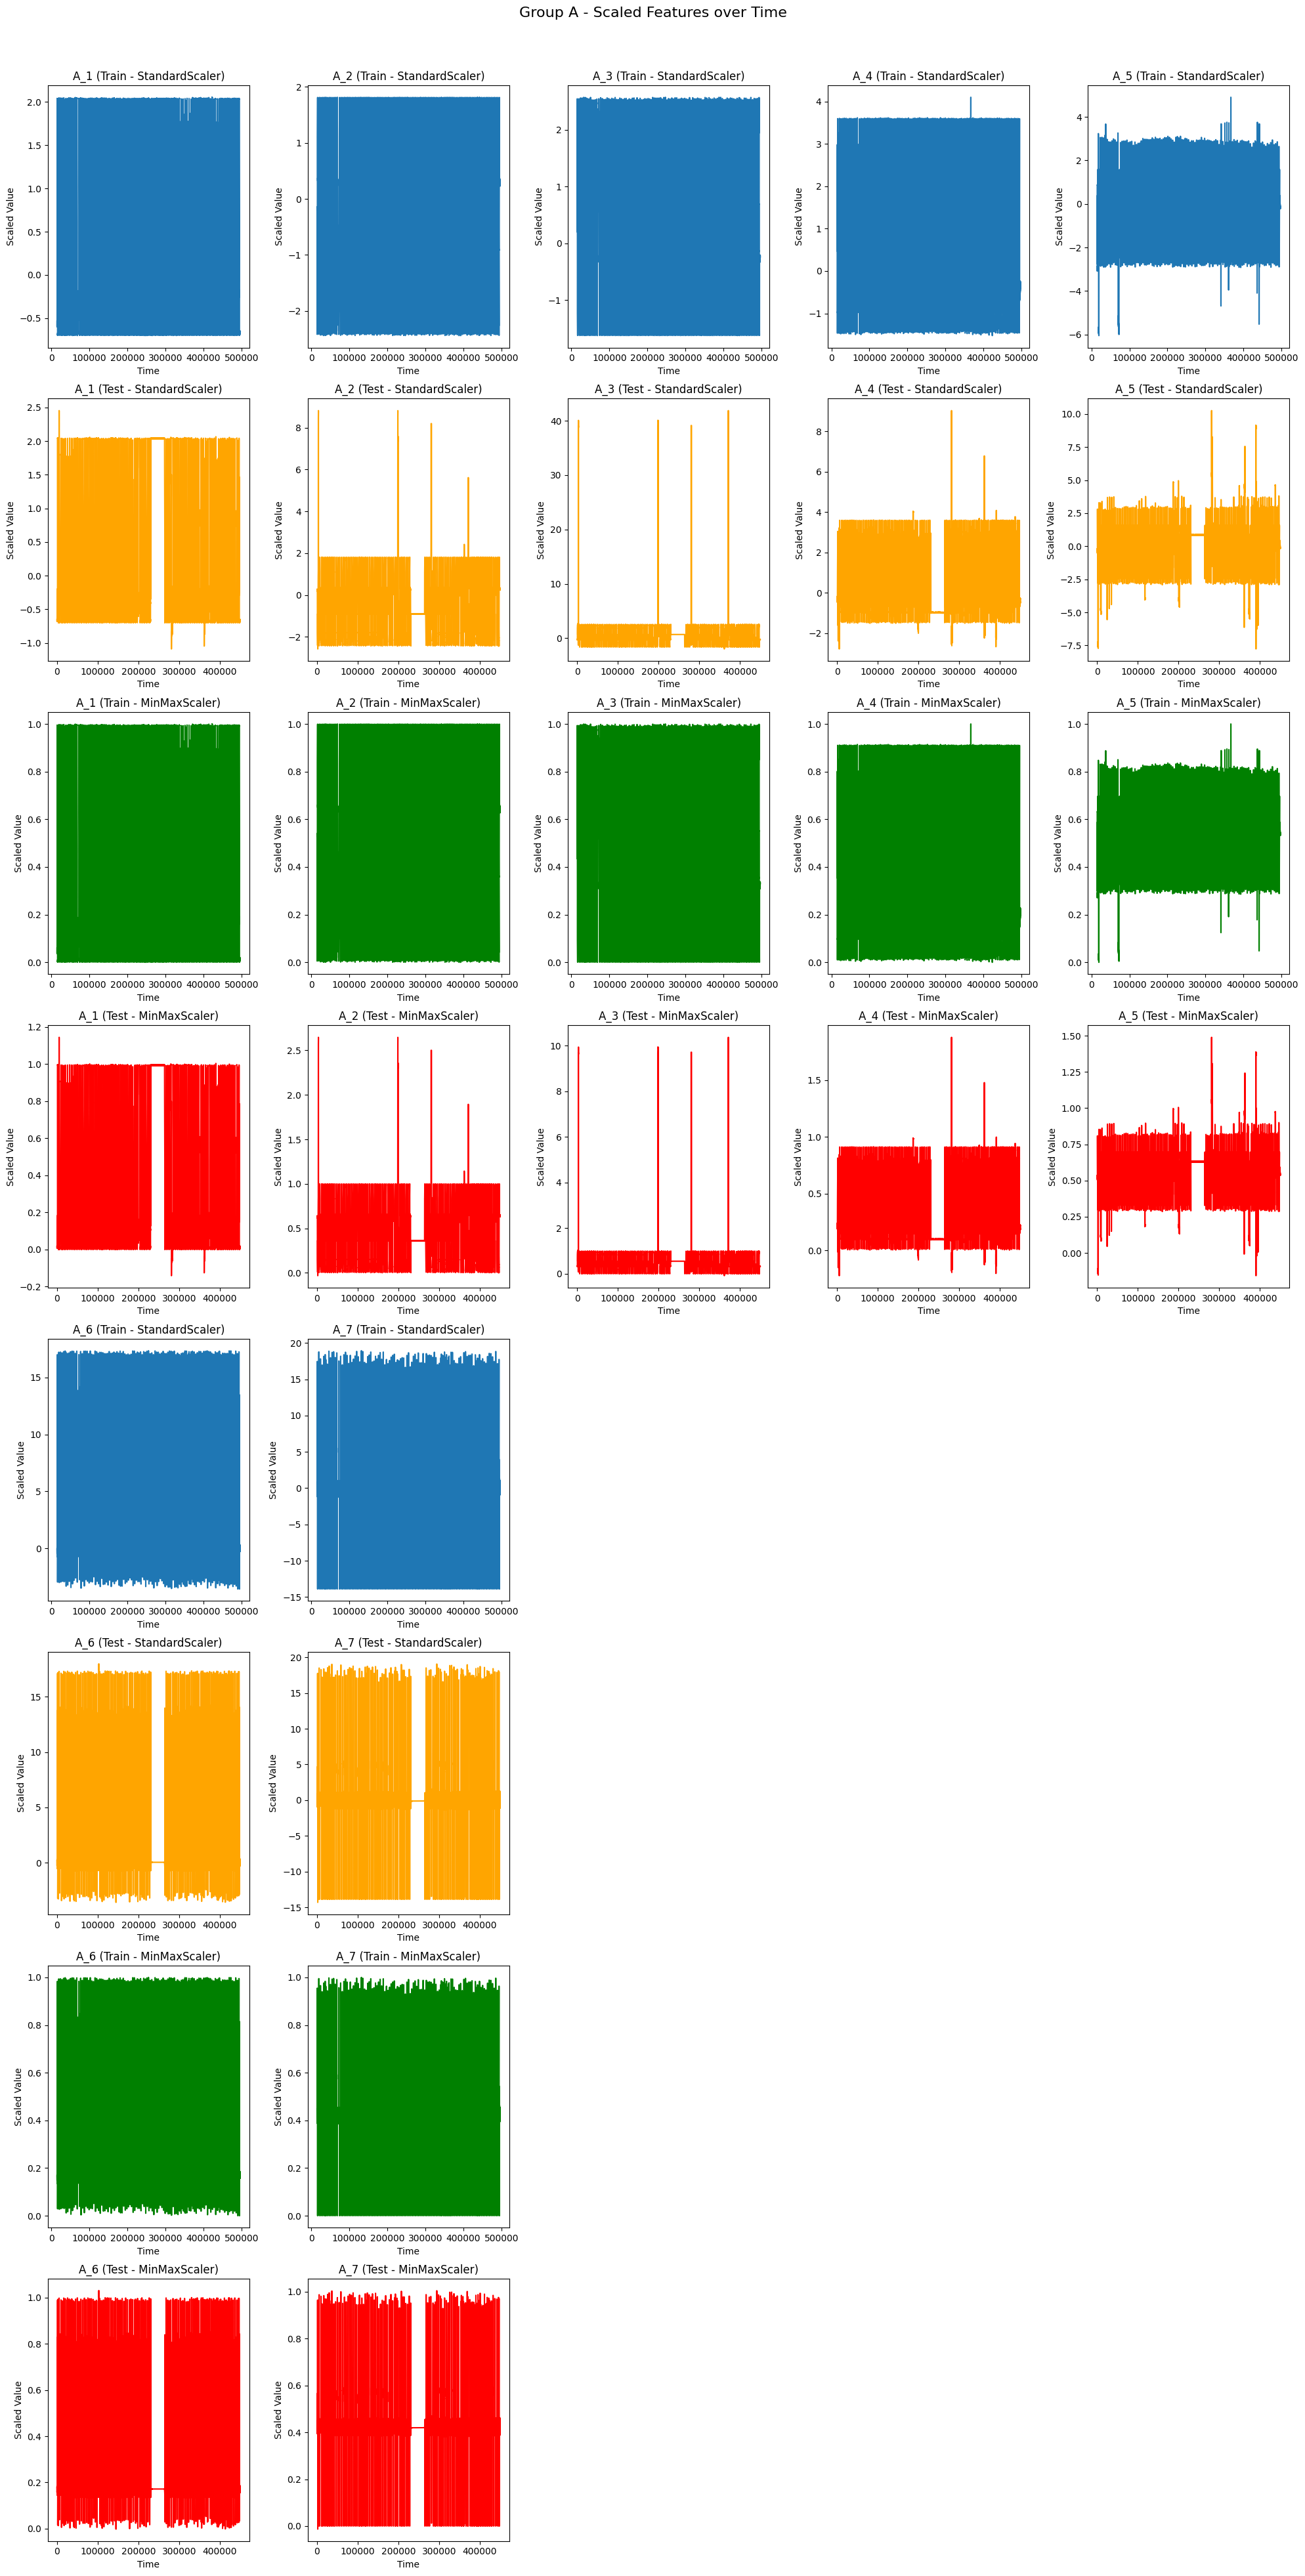

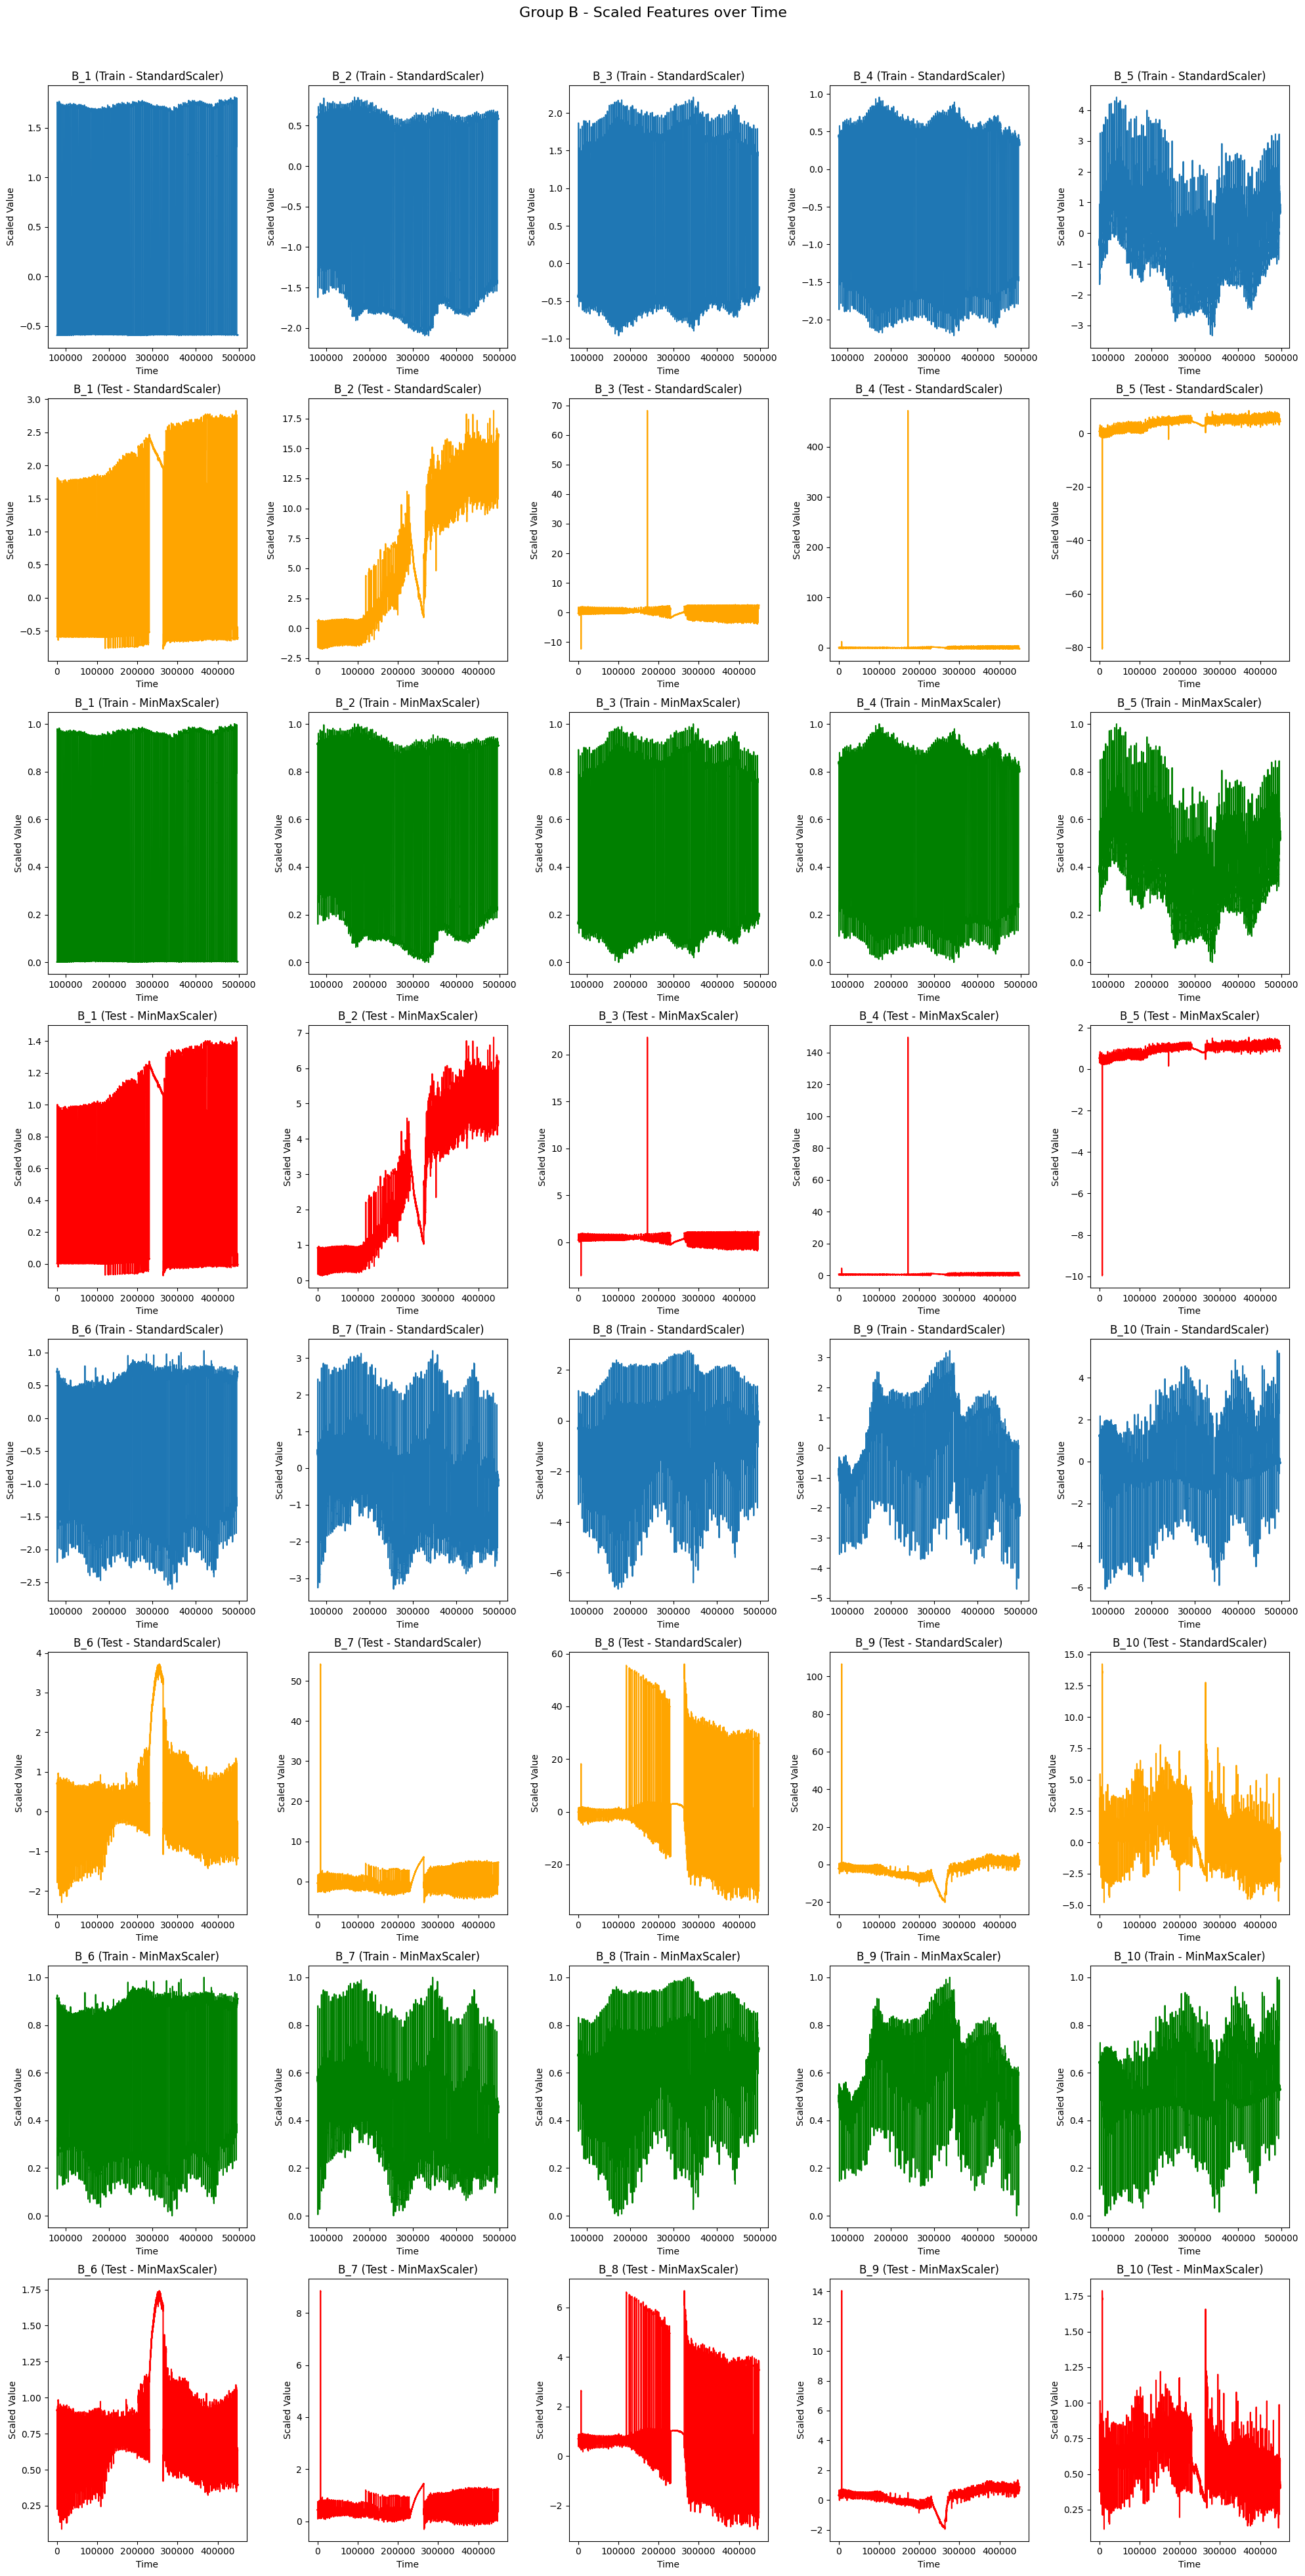

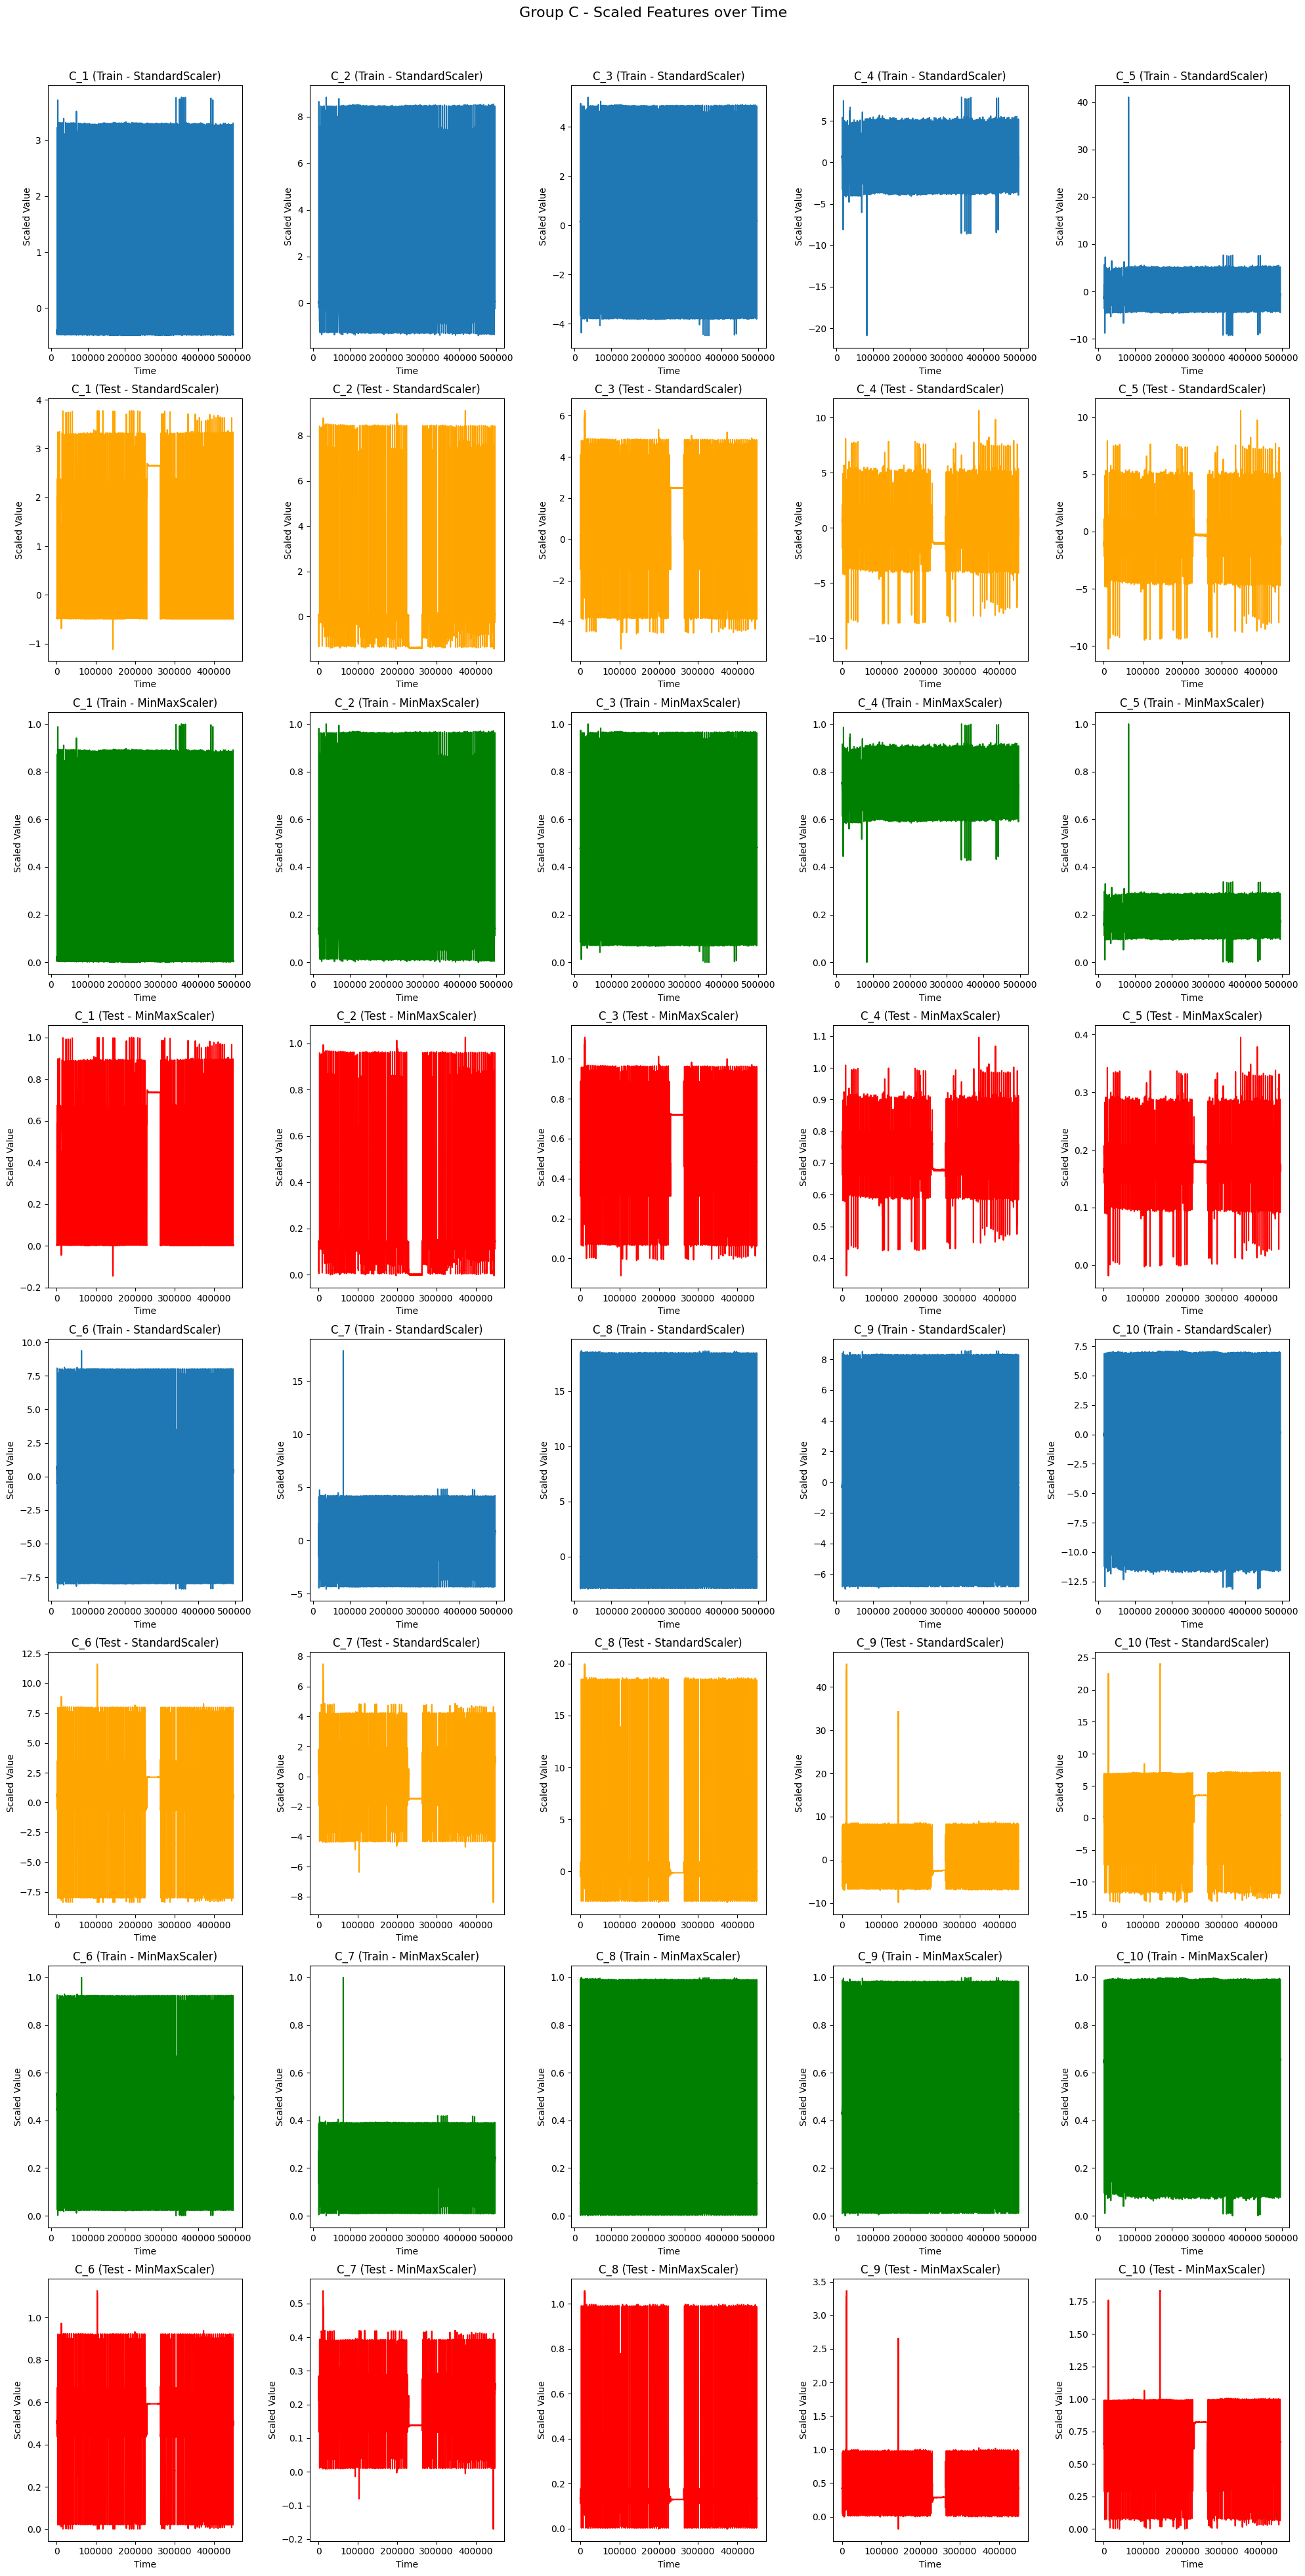

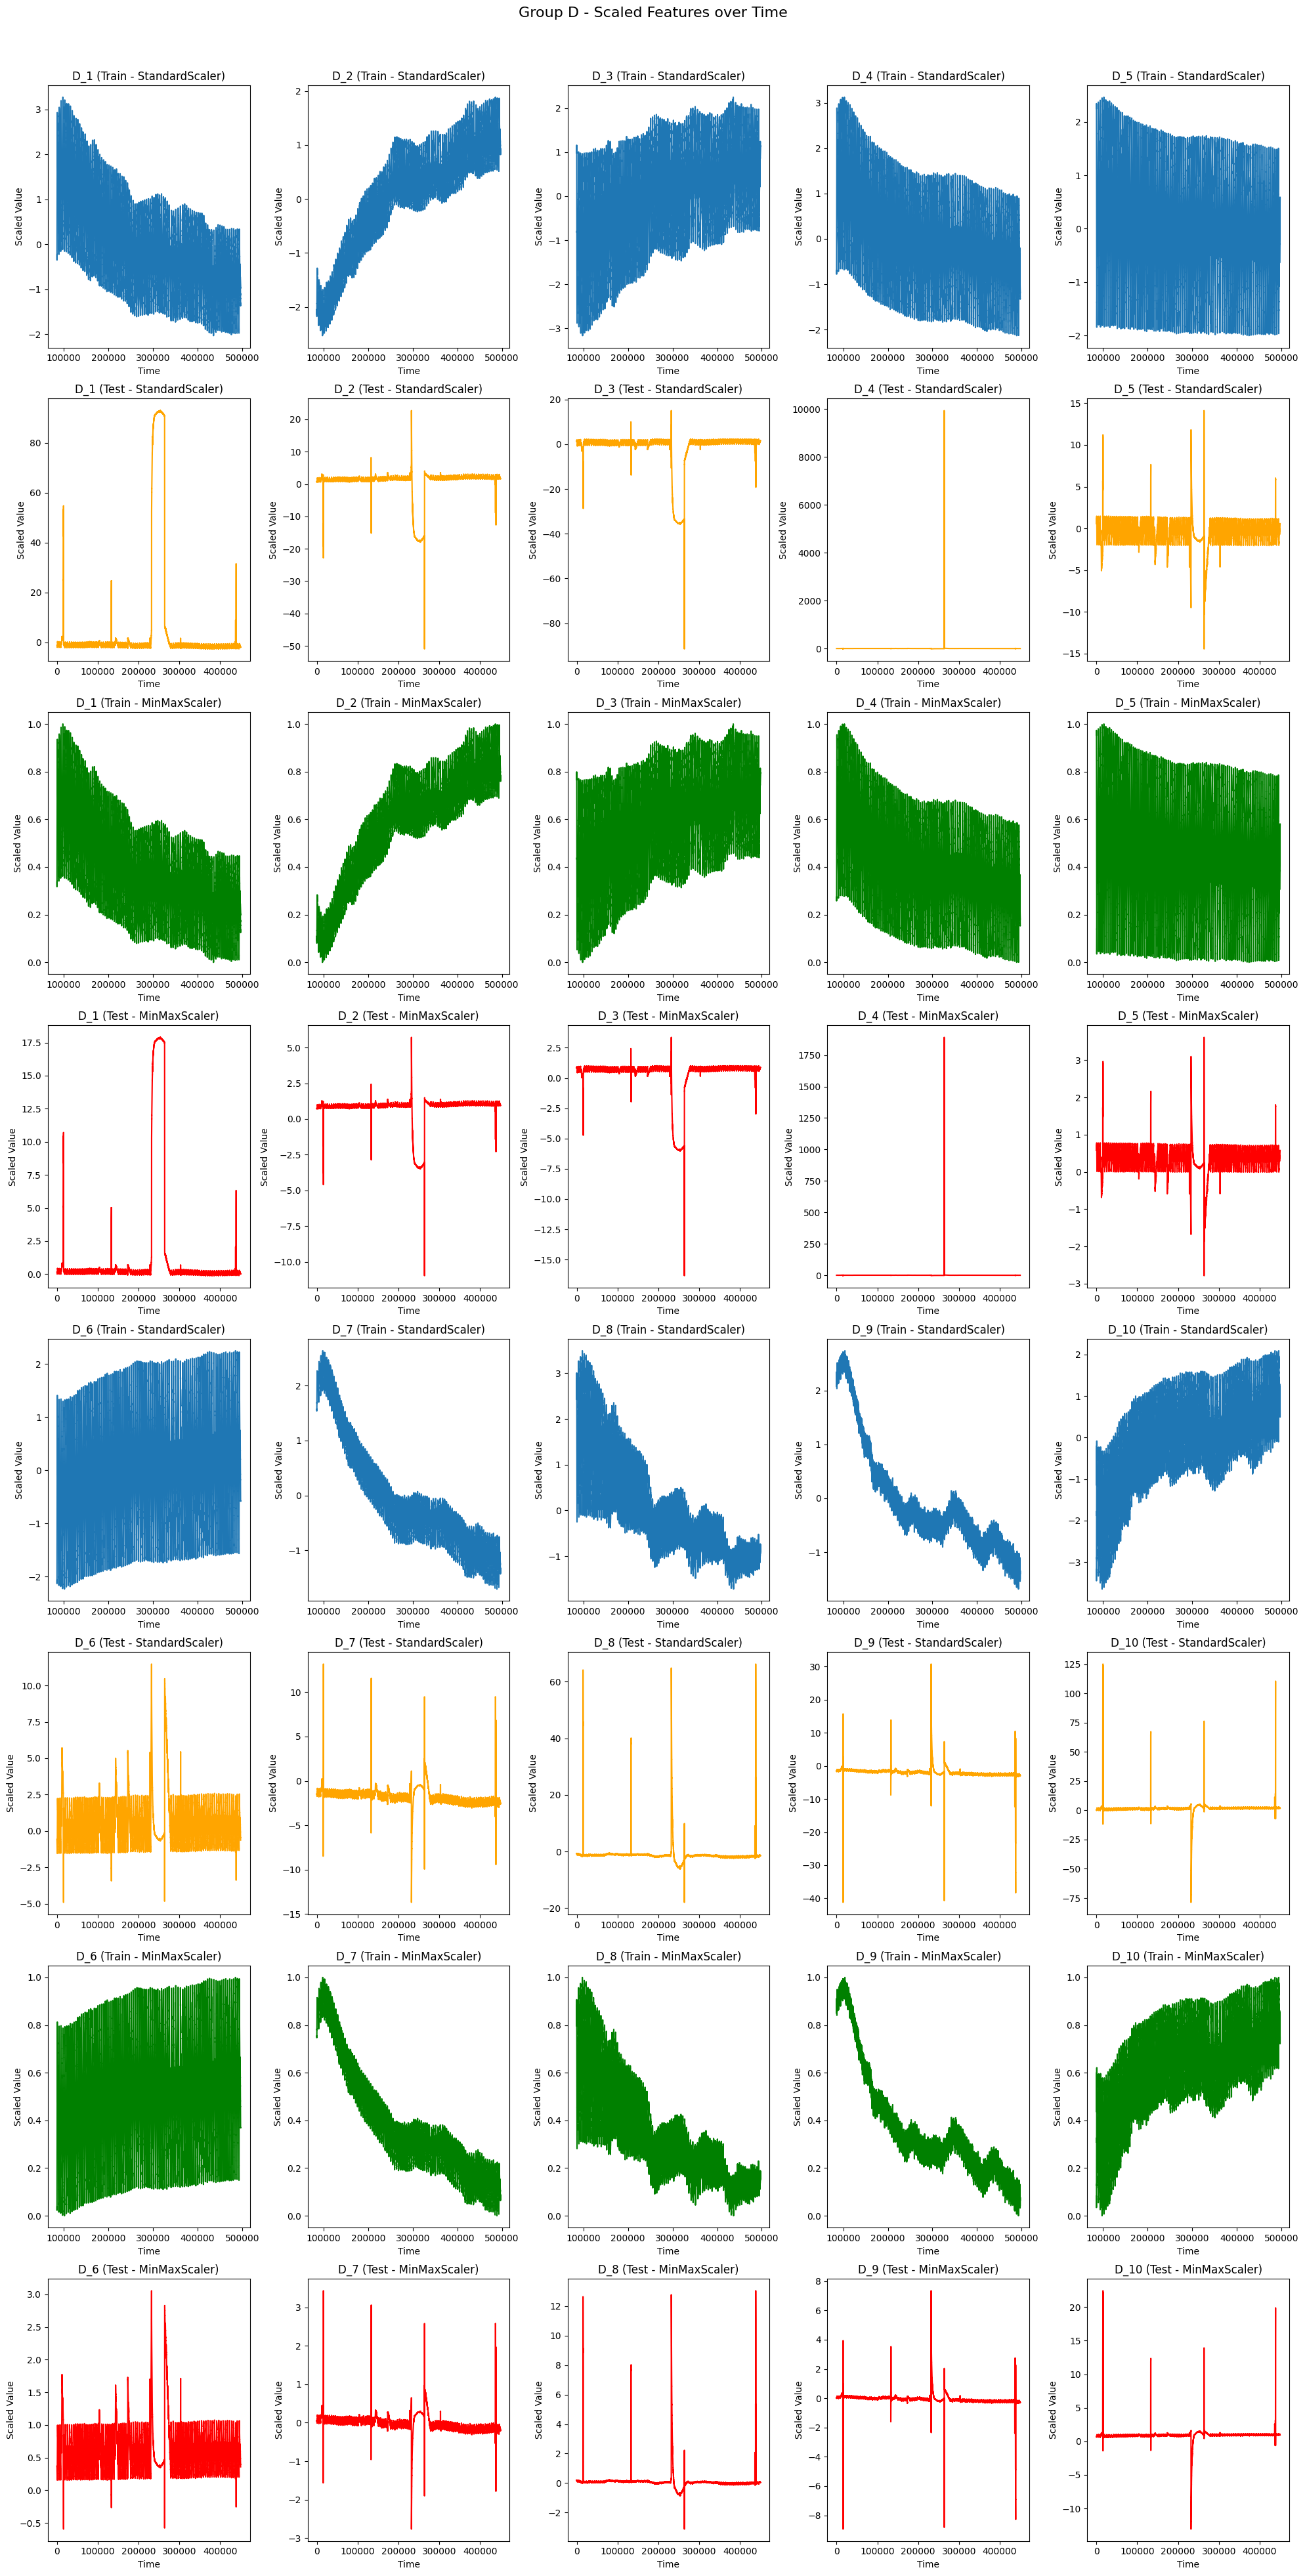

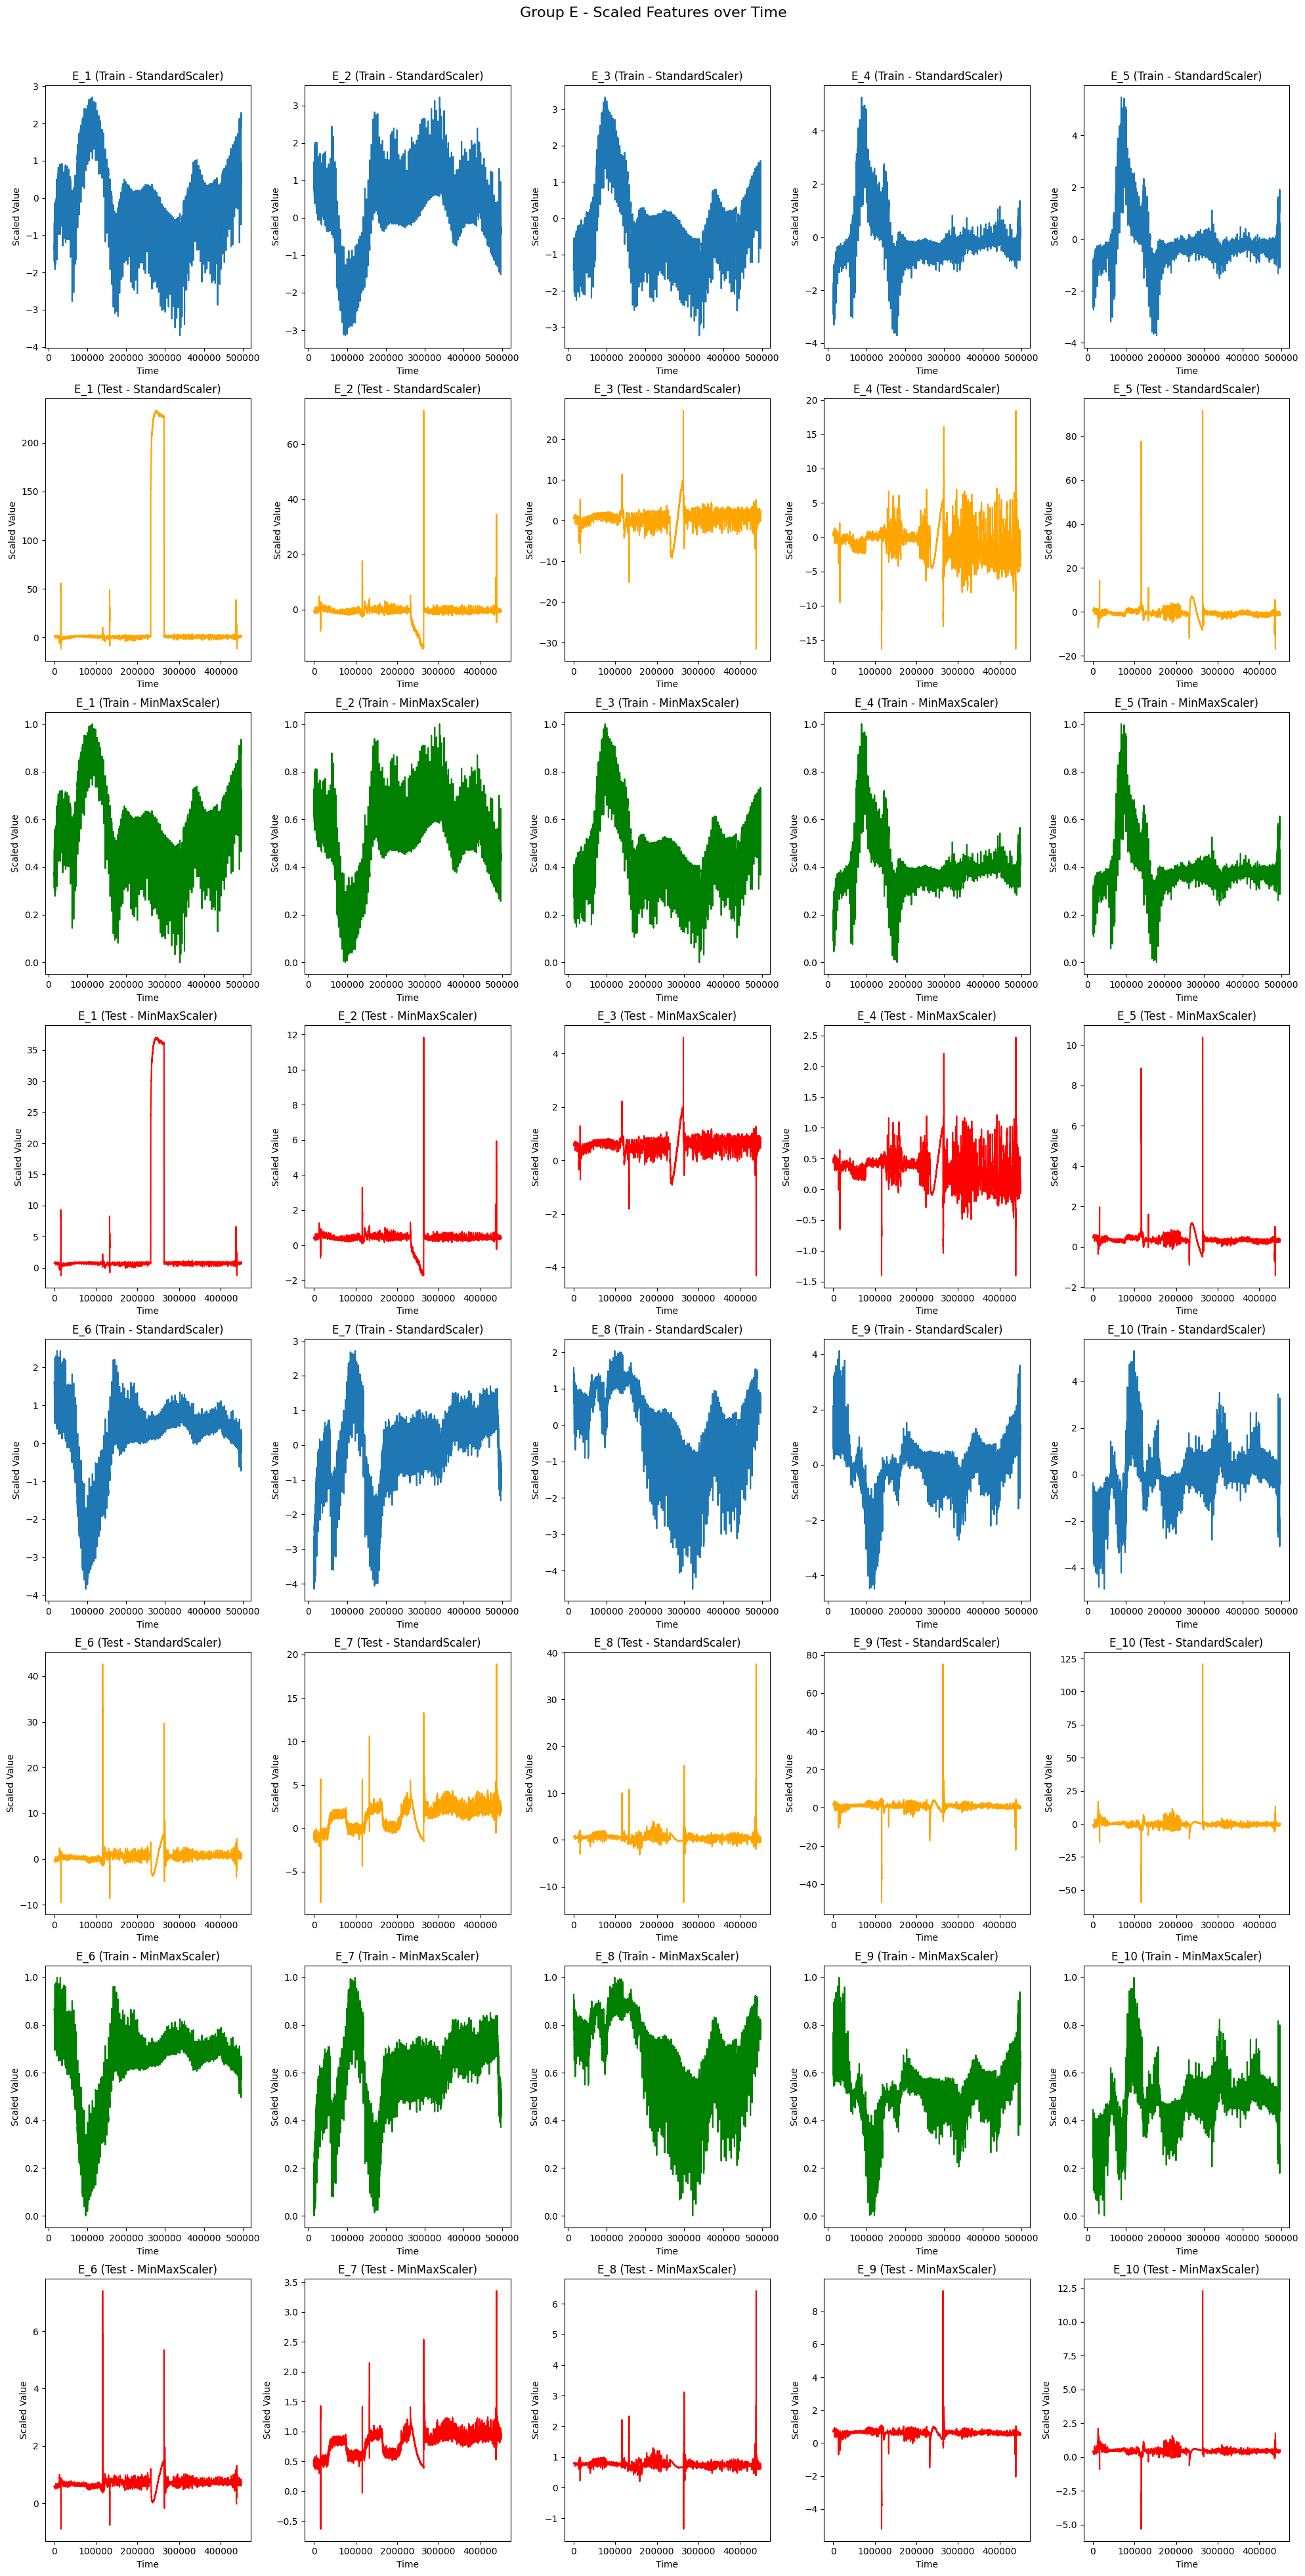

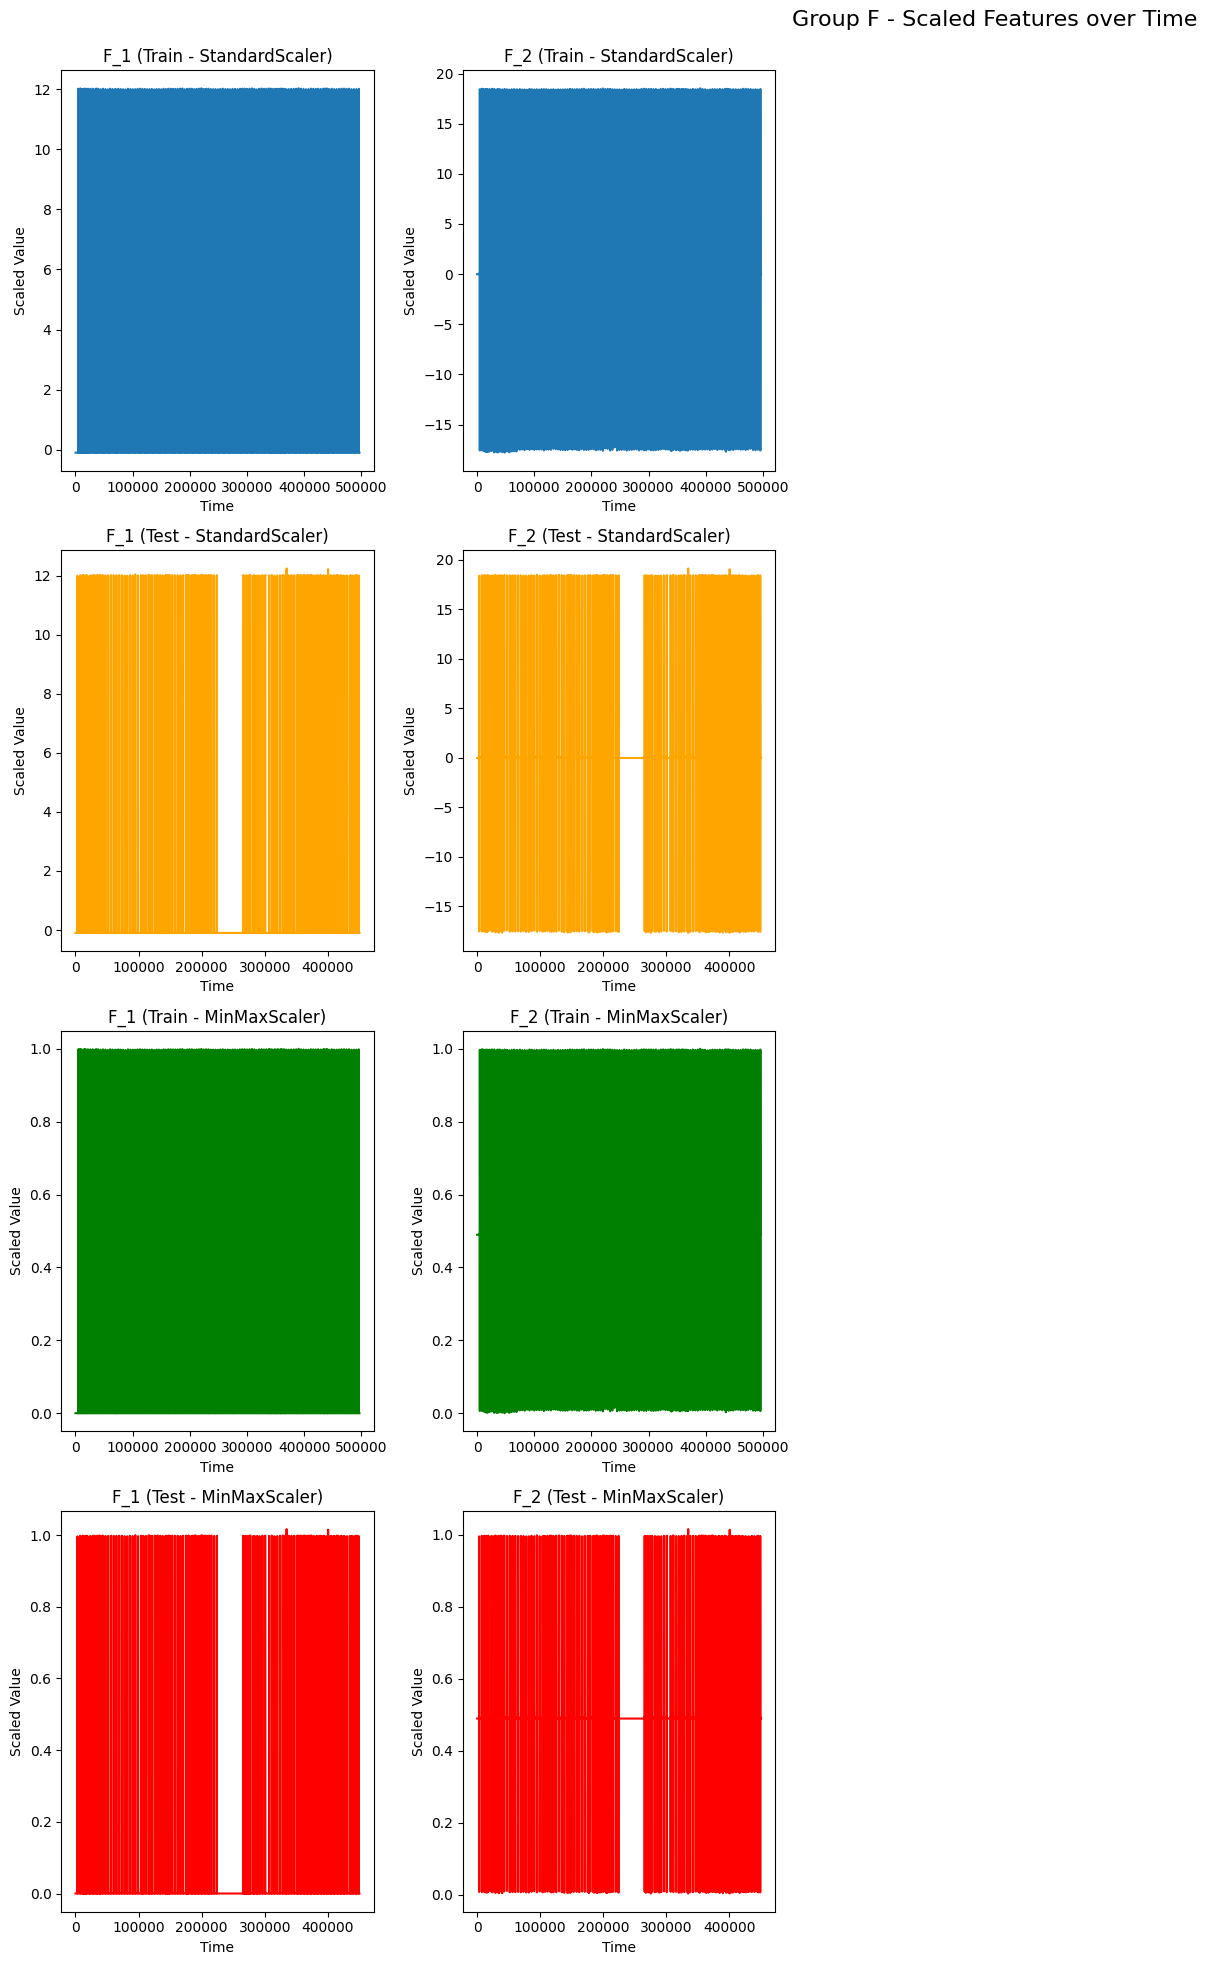

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 데이터 로드
TRAIN_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/train/train.csv")
TEST_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/test/test.csv")

# 그룹별로 특성 분류
feature_groups = {
    'A': ['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7'],
    'B': ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10'],
    'C': ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6', 'C_7', 'C_8', 'C_9', 'C_10'],
    'D': ['D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'D_9', 'D_10'],
    'E': ['E_1', 'E_2', 'E_3', 'E_4', 'E_5', 'E_6', 'E_7', 'E_8', 'E_9', 'E_10'],
    'F': ['F_1', 'F_2']
}

# 그룹별 데이터 범위 설정
group_ranges = {
    'A': (15000, None),  # 전체 데이터 사용
    'B': (80000, None),  # 8만번째부터 끝까지
    'C': (15000, None),  # 처음부터 10만번째까지
    'D': (85000, None),  # 5만번째부터 15만번째까지
    'E': (15000, None),  # 2만번째부터 끝에서 2만번째까지
    'F': (0, None)  # 전체 데이터 사용
}

# 시각화 함수
def visualize_group(group, train_df_std, test_df_std, train_df_minmax, test_df_minmax):
    features = feature_groups[group]
    n_features = len(features)
    n_rows = (n_features - 1) // 5 + 1

    fig, axes = plt.subplots(n_rows * 4, 5, figsize=(20, 5 * n_rows * 4))
    fig.suptitle(f'Group {group} - Scaled Features over Time', fontsize=16)

    for i, feature in enumerate(features):
        row = i // 5
        col = i % 5

        # StandardScaler - Train 데이터 그리기
        axes[row * 4, col].plot(train_df_std.index, train_df_std[feature])
        axes[row * 4, col].set_title(f'{feature} (Train - StandardScaler)')
        axes[row * 4, col].set_xlabel('Time')
        axes[row * 4, col].set_ylabel('Scaled Value')

        # StandardScaler - Test 데이터 그리기
        axes[row * 4 + 1, col].plot(test_df_std.index, test_df_std[feature], color='orange')
        axes[row * 4 + 1, col].set_title(f'{feature} (Test - StandardScaler)')
        axes[row * 4 + 1, col].set_xlabel('Time')
        axes[row * 4 + 1, col].set_ylabel('Scaled Value')

        # MinMaxScaler - Train 데이터 그리기
        axes[row * 4 + 2, col].plot(train_df_minmax.index, train_df_minmax[feature], color='green')
        axes[row * 4 + 2, col].set_title(f'{feature} (Train - MinMaxScaler)')
        axes[row * 4 + 2, col].set_xlabel('Time')
        axes[row * 4 + 2, col].set_ylabel('Scaled Value')

        # MinMaxScaler - Test 데이터 그리기
        axes[row * 4 + 3, col].plot(test_df_minmax.index, test_df_minmax[feature], color='red')
        axes[row * 4 + 3, col].set_title(f'{feature} (Test - MinMaxScaler)')
        axes[row * 4 + 3, col].set_xlabel('Time')
        axes[row * 4 + 3, col].set_ylabel('Scaled Value')

    # 사용하지 않는 subplot 제거
    for i in range(n_features, n_rows * 5):
        row = i // 5
        col = i % 5
        for j in range(4):
            fig.delaxes(axes[row * 4 + j, col])

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# 그룹별 데이터프레임 생성 및 스케일링
for group, features in feature_groups.items():
    # TRAIN 데이터 처리
    start, end = group_ranges[group]
    train_df = TRAIN_DF_RAW.iloc[start:end][features]

    # StandardScaler 생성 및 적용
    std_scaler = StandardScaler()
    scaled_train_std = std_scaler.fit_transform(train_df)

    # MinMaxScaler 생성 및 적용
    minmax_scaler = MinMaxScaler()
    scaled_train_minmax = minmax_scaler.fit_transform(train_df)

    # 스케일링된 TRAIN 데이터를 데이터프레임으로 변환
    train_df_std = pd.DataFrame(scaled_train_std, columns=features, index=train_df.index)
    train_df_minmax = pd.DataFrame(scaled_train_minmax, columns=features, index=train_df.index)

    # TEST 데이터 처리 (TRAIN의 scaler 사용)
    test_df = TEST_DF_RAW[features]
    scaled_test_std = std_scaler.transform(test_df)
    scaled_test_minmax = minmax_scaler.transform(test_df)

    # 스케일링된 TEST 데이터를 데이터프레임으로 변환
    test_df_std = pd.DataFrame(scaled_test_std, columns=features, index=test_df.index)
    test_df_minmax = pd.DataFrame(scaled_test_minmax, columns=features, index=test_df.index)

    # 시각화
    visualize_group(group, train_df_std, test_df_std, train_df_minmax, test_df_minmax)

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler

# # 데이터 로드
# TRAIN_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/train/train.csv")
# TEST_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/test/test.csv")

# # 그룹별로 특성 분류
# feature_groups = {
#     'A': ['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7'],
#     'B': ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10'],
#     'C': ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6', 'C_7', 'C_8', 'C_9', 'C_10'],
#     'D': ['D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'D_9', 'D_10'],
#     'E': ['E_1', 'E_2', 'E_3', 'E_4', 'E_5', 'E_6', 'E_7', 'E_8', 'E_9', 'E_10'],
#     'F': ['F_1', 'F_2']
# }

# # 시각화 함수
# def visualize_group(group, train_df, test_df):
#     features = feature_groups[group]
#     n_features = len(features)
#     n_rows = (n_features - 1) // 5 + 1

#     fig, axes = plt.subplots(n_rows * 2, 5, figsize=(20, 5 * n_rows * 2))
#     fig.suptitle(f'Group {group} - Scaled Features over Time', fontsize=16)

#     for i, feature in enumerate(features):
#         row = i // 5
#         col = i % 5

#         # Train 데이터 그리기
#         axes[row * 2, col].plot(train_df.index, train_df[feature])
#         axes[row * 2, col].set_title(f'{feature} (Train)')
#         axes[row * 2, col].set_xlabel('Time')
#         axes[row * 2, col].set_ylabel('Scaled Value')

#         # Test 데이터 그리기
#         axes[row * 2 + 1, col].plot(test_df.index, test_df[feature], color='orange')
#         axes[row * 2 + 1, col].set_title(f'{feature} (Test)')
#         axes[row * 2 + 1, col].set_xlabel('Time')
#         axes[row * 2 + 1, col].set_ylabel('Scaled Value')

#     # 사용하지 않는 subplot 제거
#     for i in range(n_features, n_rows * 5):
#         row = i // 5
#         col = i % 5
#         fig.delaxes(axes[row * 2, col])
#         fig.delaxes(axes[row * 2 + 1, col])

#     plt.tight_layout()
#     plt.subplots_adjust(top=0.95)
#     plt.show()

# # 그룹별 데이터프레임 생성 및 스케일링
# for group, features in feature_groups.items():
#     # TRAIN 데이터 처리
#     train_df = TRAIN_DF_RAW[features]

#     # StandardScaler 생성 및 적용
#     scaler = StandardScaler()
#     scaled_train = scaler.fit_transform(train_df)

#     # 스케일링된 TRAIN 데이터를 데이터프레임으로 변환
#     train_df_scaled = pd.DataFrame(scaled_train, columns=features, index=train_df.index)

#     # TEST 데이터 처리 (TRAIN의 scaler 사용)
#     test_df = TEST_DF_RAW[features]
#     scaled_test = scaler.transform(test_df)

#     # 스케일링된 TEST 데이터를 데이터프레임으로 변환
#     test_df_scaled = pd.DataFrame(scaled_test, columns=features, index=test_df.index)

#     # 시각화
#     visualize_group(group, train_df_scaled, test_df_scaled)

In [ ]:
# import pandas as pd
# import numpy as np

# # 데이터 로드
# TRAIN_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/train/train.csv")
# TEST_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/test/test.csv")

# # 그룹별로 특성 분류
# feature_groups = {
#     'A': ['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7'],
#     'B': ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10'],
#     'C': ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6', 'C_7', 'C_8', 'C_9', 'C_10'],
#     'D': ['D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'D_9', 'D_10'],
#     'E': ['E_1', 'E_2', 'E_3', 'E_4', 'E_5', 'E_6', 'E_7', 'E_8', 'E_9', 'E_10'],
#     'F': ['F_1', 'F_2']
# }

# # Min/Max 정규화 함수
# def min_max_normalize(df, min_vals, max_vals):
#     return (df - min_vals) / (max_vals - min_vals)

# # 그룹별 데이터프레임 생성 및 정규화
# for group, features in feature_groups.items():
#     # TRAIN 데이터 처리
#     train_df = TRAIN_DF_RAW[features]
#     train_min = train_df.min()
#     train_max = train_df.max()

#     globals()[f'TRAIN_DF_{group}'] = min_max_normalize(train_df, train_min, train_max)

#     # TEST 데이터 처리 (TRAIN의 min, max 사용)
#     test_df = TEST_DF_RAW[features]
#     globals()[f'TEST_DF_{group}'] = min_max_normalize(test_df, train_min, train_max)

# # 생성된 데이터프레임 확인 및 기본 통계 출력
# for group in feature_groups.keys():
#     train_df = globals()[f'TRAIN_DF_{group}']
#     test_df = globals()[f'TEST_DF_{group}']

#     print(f"=== Group {group} ===")
#     print(f"TRAIN_DF_{group} 형태:", train_df.shape)
#     print(f"TEST_DF_{group} 형태:", test_df.shape)

#     print(f"\nTRAIN_DF_{group} 기본 통계:")
#     print(train_df.describe())

#     print(f"\nTEST_DF_{group} 기본 통계:")
#     print(test_df.describe())

#     print("\n" + "="*50 + "\n")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 데이터 로드
TRAIN_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/train/train.csv")
TEST_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/test/test.csv")

# 그룹별로 특성 분류
feature_groups = {
    'A': ['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7'],
    'B': ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10'],
    'C': ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6', 'C_7', 'C_8', 'C_9', 'C_10'],
    'D': ['D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'D_9', 'D_10'],
    'E': ['E_1', 'E_2', 'E_3', 'E_4', 'E_5', 'E_6', 'E_7', 'E_8', 'E_9', 'E_10'],
    'F': ['F_1', 'F_2']
}

# 그룹별 데이터 범위 설정
group_ranges = {
    'A': (15000, None),  # 전체 데이터 사용
    'B': (80000, None),  # 8만번째부터 끝까지
    'C': (15000, None),  # 처음부터 10만번째까지
    'D': (85000, None),  # 5만번째부터 15만번째까지
    'E': (15000, None),  # 2만번째부터 끝에서 2만번째까지
    'F': (0, None)  # 전체 데이터 사용
}


# 그룹별 데이터프레임 생성 및 스케일링
for group, features in feature_groups.items():
    # TRAIN 데이터 처리
    start, end = group_ranges[group]
    train_df = TRAIN_DF_RAW.iloc[start:end][features]

    # StandardScaler 생성 및 적용
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(train_df)

    # 스케일링된 TRAIN 데이터를 데이터프레임으로 변환
    globals()[f'TRAIN_DF_{group}'] = pd.DataFrame(scaled_train, columns=features, index=train_df.index)

    # TEST 데이터 처리 (TRAIN의 scaler 사용)
    test_df = TEST_DF_RAW[features]
    scaled_test = scaler.transform(test_df)

    # 스케일링된 TEST 데이터를 데이터프레임으로 변환
    globals()[f'TEST_DF_{group}'] = pd.DataFrame(scaled_test, columns=features, index=test_df.index)

# 생성된 데이터프레임 확인 및 기본 통계 출력
for group in feature_groups.keys():
    train_df = globals()[f'TRAIN_DF_{group}']
    test_df = globals()[f'TEST_DF_{group}']

    print(f"=== Group {group} ===")
    print(f"TRAIN_DF_{group} 형태:", train_df.shape)
    print(f"TEST_DF_{group} 형태:", test_df.shape)

    print(f"\nTRAIN_DF_{group} 기본 통계:")
    print(train_df.describe())

    print(f"\nTEST_DF_{group} 기본 통계:")
    print(test_df.describe())

    print("\n" + "="*50 + "\n")

=== Group A ===
TRAIN_DF_A 형태: (481800, 7)
TEST_DF_A 형태: (450000, 7)

TRAIN_DF_A 기본 통계:
                A_1           A_2           A_3           A_4           A_5  \
count  4.818000e+05  4.818000e+05  4.818000e+05  4.818000e+05  4.818000e+05   
mean  -6.465378e-17  1.038236e-17  1.462969e-17 -1.805115e-17  6.606956e-18   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -7.015044e-01 -2.438809e+00 -1.623606e+00 -1.523013e+00 -6.046345e+00   
25%   -6.741201e-01 -9.034865e-01 -3.109285e-01 -5.240655e-01 -2.820963e-01   
50%   -6.550576e-01  2.781313e-01 -2.498256e-01 -3.766776e-01  5.649953e-02   
75%    8.211788e-01  3.353875e-01  6.877287e-01  2.812450e-01  3.930388e-01   
max    2.055518e+00  1.813944e+00  2.571928e+00  4.099084e+00  4.901788e+00   

                A_6           A_7  
count  4.818000e+05  4.818000e+05  
mean  -2.108917e-18 -6.636451e-18  
std    1.000001e+00  1.000001e+00  
min   -3.561818e+00 -1.389338e+01  
25%   -2.037632e-01 

In [ ]:
import numpy as np

def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i+window_size])
    return np.array(windows)

window_size = 30

# 각 그룹에 대해 윈도우 생성
for group in feature_groups.keys():
    train_df = globals()[f'TRAIN_DF_{group}']
    test_df = globals()[f'TEST_DF_{group}']

    # TRAIN 데이터에 대한 윈도우 생성
    train_windows = create_windows(train_df.values, window_size)
    globals()[f'TRAIN_WINDOWS_{group}'] = train_windows

    # TEST 데이터에 대한 윈도우 생성
    test_windows = create_windows(test_df.values, window_size)
    globals()[f'TEST_WINDOWS_{group}'] = test_windows

    print(f"=== Group {group} ===")
    print(f"Original TRAIN_DF_{group} shape:", train_df.shape)
    print(f"After windowing, TRAIN_WINDOWS_{group} shape:", train_windows.shape)
    print(f"\nOriginal TEST_DF_{group} shape:", test_df.shape)
    print(f"After windowing, TEST_WINDOWS_{group} shape:", test_windows.shape)
    print("\n" + "="*50 + "\n")

=== Group A ===
Original TRAIN_DF_A shape: (481800, 7)
After windowing, TRAIN_WINDOWS_A shape: (481771, 30, 7)

Original TEST_DF_A shape: (450000, 7)
After windowing, TEST_WINDOWS_A shape: (449971, 30, 7)


=== Group B ===
Original TRAIN_DF_B shape: (416800, 10)
After windowing, TRAIN_WINDOWS_B shape: (416771, 30, 10)

Original TEST_DF_B shape: (450000, 10)
After windowing, TEST_WINDOWS_B shape: (449971, 30, 10)


=== Group C ===
Original TRAIN_DF_C shape: (481800, 10)
After windowing, TRAIN_WINDOWS_C shape: (481771, 30, 10)

Original TEST_DF_C shape: (450000, 10)
After windowing, TEST_WINDOWS_C shape: (449971, 30, 10)


=== Group D ===
Original TRAIN_DF_D shape: (411800, 10)
After windowing, TRAIN_WINDOWS_D shape: (411771, 30, 10)

Original TEST_DF_D shape: (450000, 10)
After windowing, TEST_WINDOWS_D shape: (449971, 30, 10)


=== Group E ===
Original TRAIN_DF_E shape: (481800, 10)
After windowing, TRAIN_WINDOWS_E shape: (481771, 30, 10)

Original TEST_DF_E shape: (450000, 10)
After w

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split

def create_complex_autoencoder(input_shape):
    def create_branch(alpha):
        return models.Sequential([
            # Encoder
            layers.Conv1D(32, kernel_size=5, activation=tf.keras.layers.LeakyReLU(alpha=alpha), padding='same', input_shape=input_shape),
            layers.Conv1D(32, kernel_size=5, activation=tf.keras.layers.LeakyReLU(alpha=alpha), padding='same'),
            layers.Conv1D(16, kernel_size=5, activation=tf.keras.layers.LeakyReLU(alpha=alpha), padding='same'),
            layers.Conv1D(8, kernel_size=5, activation=tf.keras.layers.LeakyReLU(alpha=alpha), padding='same'),

            # Decoder
            layers.Conv1D(8, kernel_size=5, activation=tf.keras.layers.LeakyReLU(alpha=alpha), padding='same'),
            layers.Conv1D(16, kernel_size=5, activation=tf.keras.layers.LeakyReLU(alpha=alpha), padding='same'),
            layers.Conv1D(32, kernel_size=5, activation=tf.keras.layers.LeakyReLU(alpha=alpha), padding='same'),
            layers.Conv1D(32, kernel_size=5, activation=tf.keras.layers.LeakyReLU(alpha=alpha), padding='same'),
            layers.Conv1D(input_shape[-1], kernel_size=5, activation='linear', padding='same')
        ])

    # Create two branches with different Leaky ReLU alphas
    branch_02 = create_branch(0.2)
    branch_001 = create_branch(0.01)

    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Pass input through both branches
    output_02 = branch_02(inputs)
    output_001 = branch_001(inputs)

    # Average the outputs
    outputs = layers.Average()([output_02, output_001])

    # Create the final model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Learning rate reduction callback
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,
    patience=3,
    min_lr=1e-6
)

# 각 그룹에 대해 모델 생성 및 학습
for group in feature_groups.keys():
    print(f"Processing group {group}")

    # 데이터 준비
    all_train_data = globals()[f'TRAIN_WINDOWS_{group}']
    test_data = globals()[f'TEST_WINDOWS_{group}']

    # 훈련 데이터를 훈련 세트와 검증 세트로 랜덤하게 분할
    train_data, val_data = train_test_split(all_train_data, test_size=0.02, random_state=42)

    # 입력 형태 정의 (시계열 길이, 특성 수)
    input_shape = (train_data.shape[1], train_data.shape[2])

    # 모델 생성
    model = create_complex_autoencoder(input_shape)
    model.compile(optimizer='adam', loss='mse')

    # 모델 학습
    history = model.fit(
        train_data, train_data,
        epochs = 30,  # Increase max epochs, early stopping will prevent overfitting
        batch_size = 32,
        validation_data=(val_data, val_data),
        callbacks=[early_stopping, lr_reducer],
        verbose=1
    )

    # 모델 평가
    test_loss = model.evaluate(test_data, test_data, verbose=0)
    print(f"Test loss for group {group}: {test_loss}")

    # 모델 저장
    model.save(f'complex_autoencoder_model_{group}.h5')

    print(f"Finished processing group {group}")
    print("=" * 50)

# 학습된 모델을 사용하여 특성 추출 또는 이상 탐지
def extract_features(model, data):
    # 인코더 부분만 추출 (마지막 8차원 레이어까지)
    encoder = models.Model(inputs=model.inputs, outputs=model.layers[3].output)
    return encoder.predict(data)

# 예시: A 그룹의 특성 추출
model_A = models.load_model('complex_autoencoder_model_A.h5')
features_A = extract_features(model_A, globals()['TEST_WINDOWS_A'])
print("Extracted features shape for group A:", features_A.shape)

Processing group A
Epoch 1/30
14755/14755 [==============================] - 95s 6ms/step - loss: 0.0098 - val_loss: 7.0362e-04 - lr: 0.0010
Epoch 2/30
14755/14755 [==============================] - 87s 6ms/step - loss: 0.0019 - val_loss: 0.0014 - lr: 0.0010
Epoch 3/30
14755/14755 [==============================] - 86s 6ms/step - loss: 0.0012 - val_loss: 3.7158e-04 - lr: 0.0010
Epoch 4/30
14755/14755 [==============================] - 87s 6ms/step - loss: 8.0033e-04 - val_loss: 2.3303e-04 - lr: 0.0010
Epoch 5/30
14755/14755 [==============================] - 91s 6ms/step - loss: 6.0887e-04 - val_loss: 1.4109e-04 - lr: 0.0010
Epoch 6/30
14755/14755 [==============================] - 89s 6ms/step - loss: 4.6253e-04 - val_loss: 1.5628e-04 - lr: 0.0010
Epoch 7/30
14755/14755 [==============================] - 85s 6ms/step - loss: 4.0459e-04 - val_loss: 1.4896e-04 - lr: 0.0010
Epoch 8/30
14755/14755 [==============================] - 89s 6ms/step - loss: 2.7920e-04 - val_loss: 7.3733e-05 - 

In [ ]:
#model.save('C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_AD_2408/modelsave/240907/240907_Window30_MinMax_EachFeature_SOTA633')
# print("모델이 'ensemble_autoencoder_model.h5' 파일로 저장되었습니다.")

14062/14062 [==============================] - 27s 2ms/step
Group A:
Train Error - Mean: 0.0000, Std: 0.0002
Test Error  - Mean: 1.3617, Std: 15.4690
14062/14062 [==============================] - 29s 2ms/step
Group B:
Train Error - Mean: 0.0000, Std: 0.0001
Test Error  - Mean: 17.3692, Std: 238.1854
14062/14062 [==============================] - 31s 2ms/step
Group C:
Train Error - Mean: 0.0008, Std: 0.0657
Test Error  - Mean: 0.1482, Std: 2.0129
14062/14062 [==============================] - 31s 2ms/step
Group D:
Train Error - Mean: 0.0000, Std: 0.0000
Test Error  - Mean: 1084.2997, Std: 81681.2323
14062/14062 [==============================] - 27s 2ms/step
Group E:
Train Error - Mean: 0.0003, Std: 0.0004
Test Error  - Mean: 215.7970, Std: 780.3146
14062/14062 [==============================] - 26s 2ms/step
Group F:
Train Error - Mean: 0.0022, Std: 0.1286
Test Error  - Mean: 0.0028, Std: 0.1335


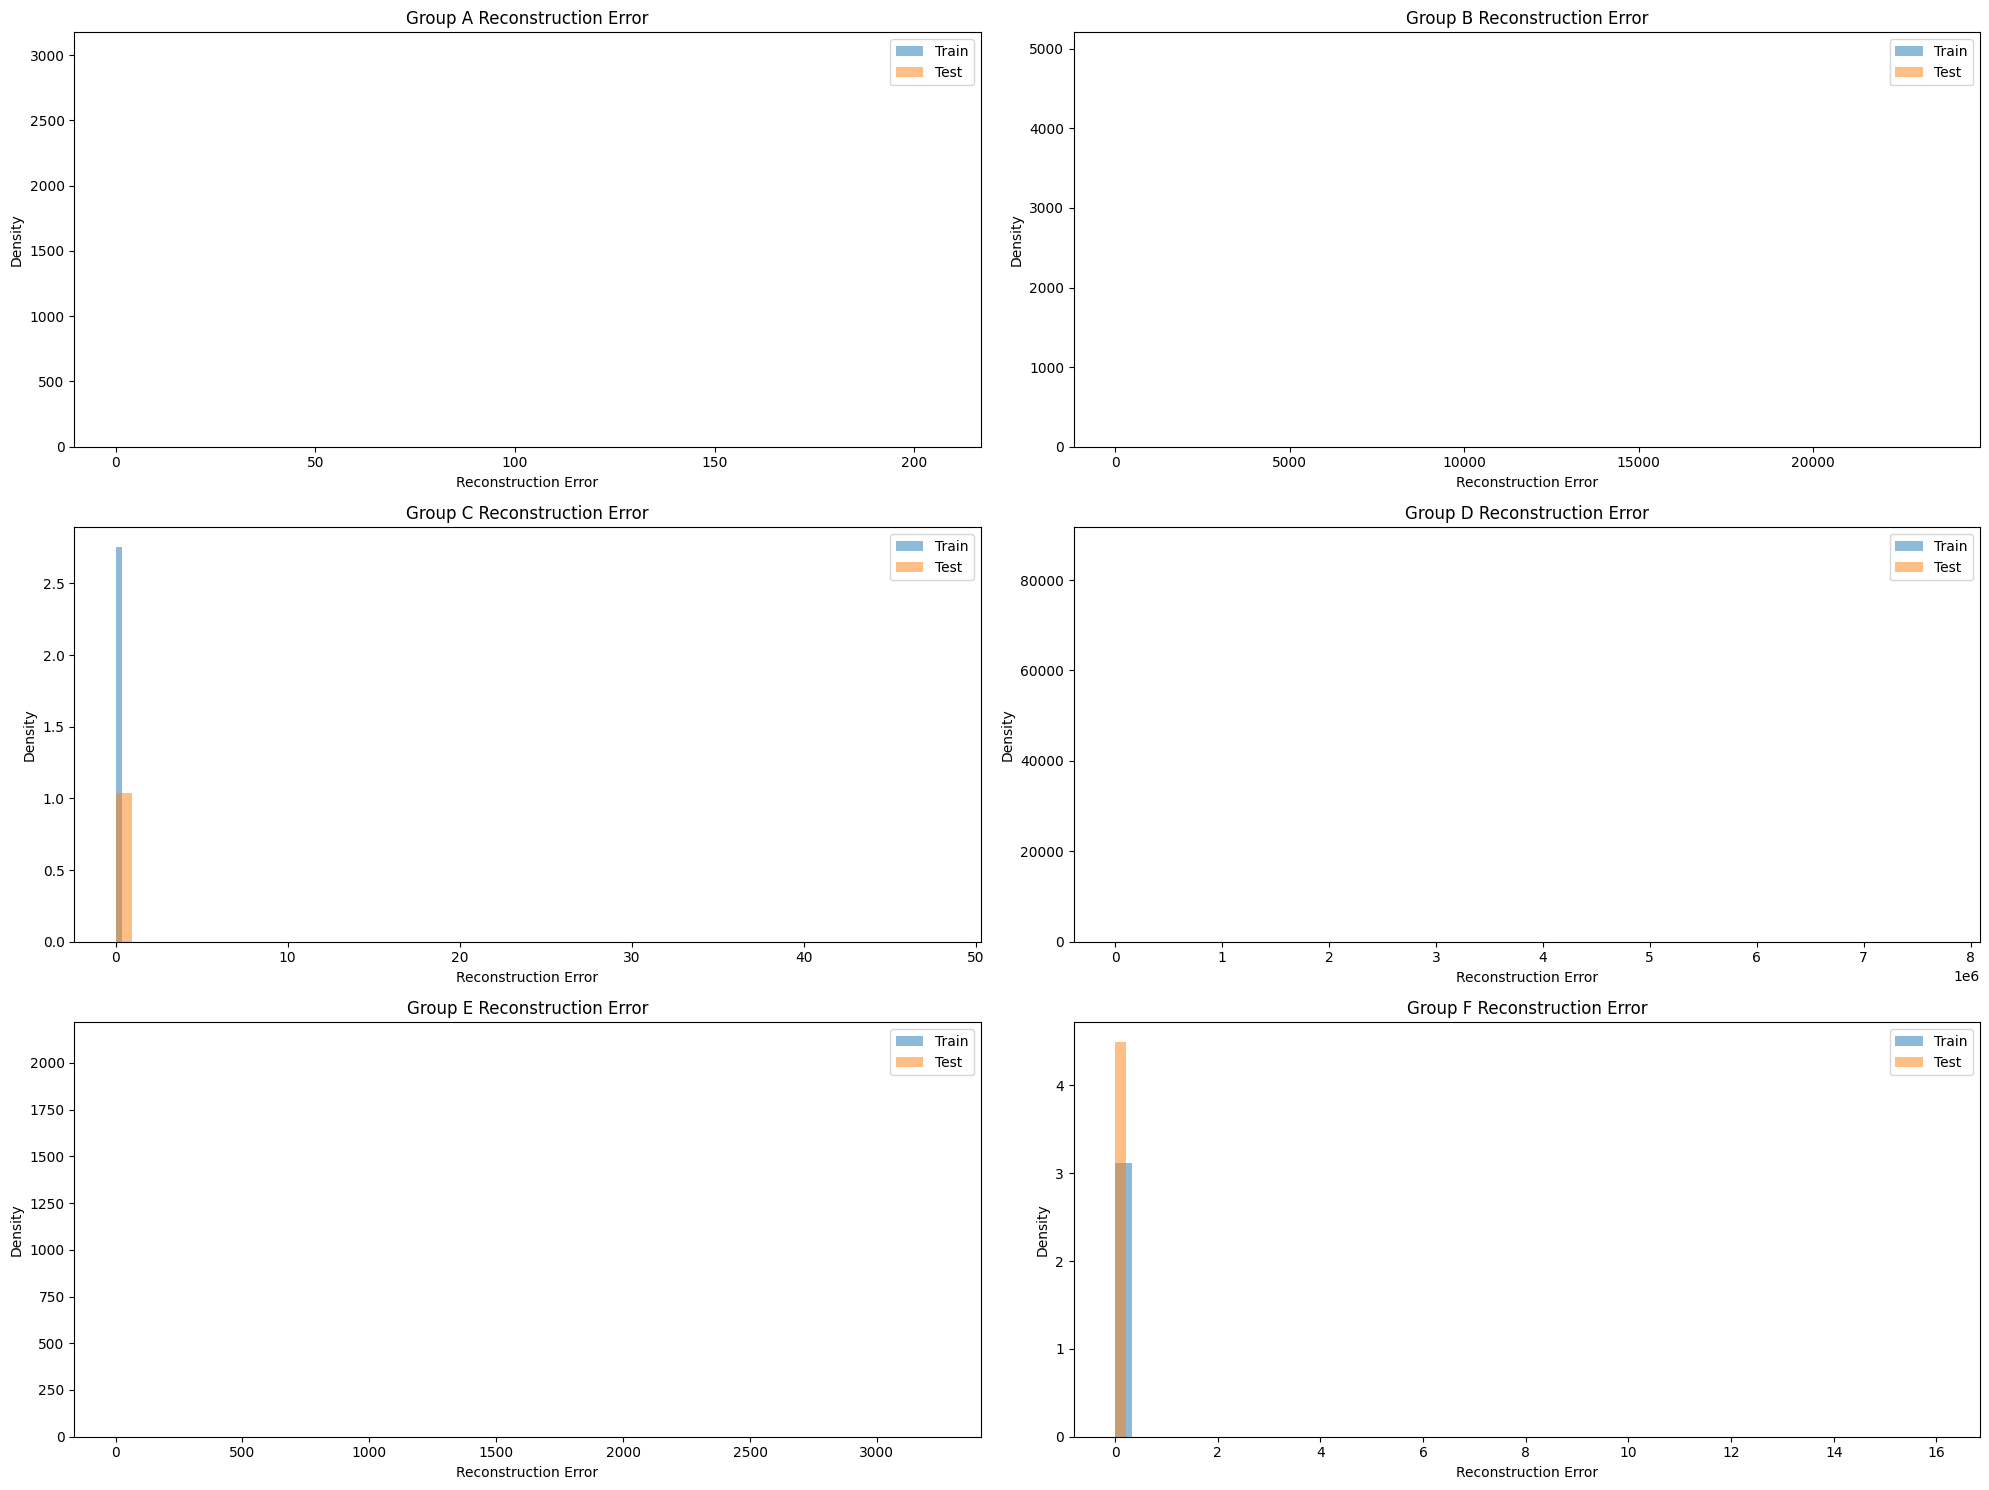

14062/14062 [==============================] - 26s 2ms/step


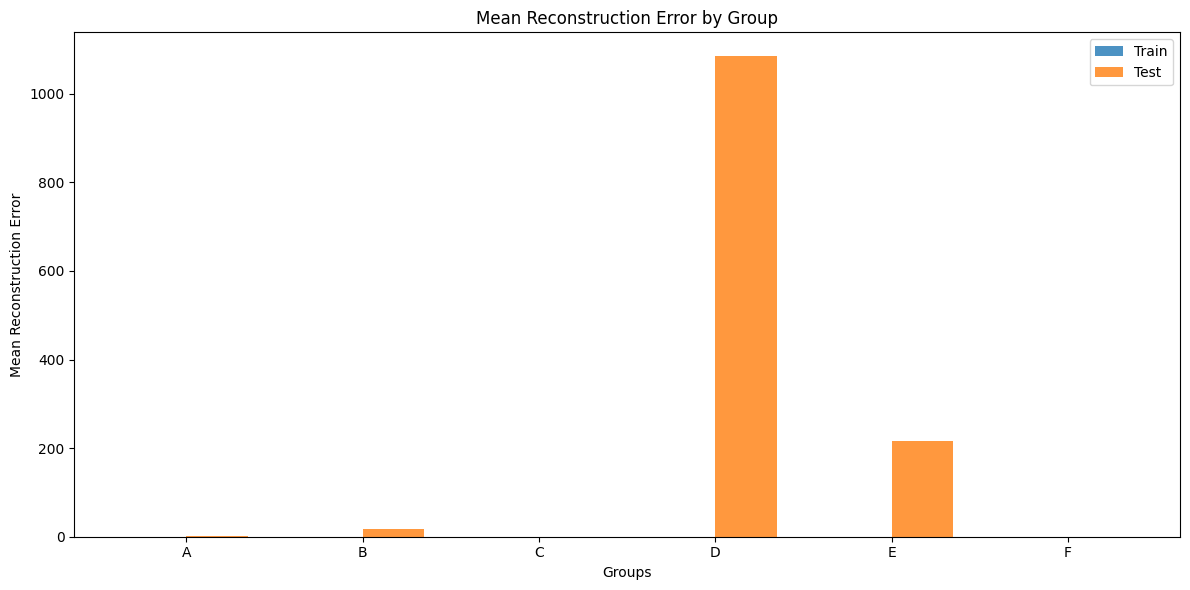

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def calculate_reconstruction_error(model, data):
    predictions = model.predict(data)
    mse = np.mean(np.square(data - predictions), axis=(1, 2))
    return mse

plt.figure(figsize=(20, 15))

for idx, group in enumerate(feature_groups.keys(), 1):
    # 모델 로드
    model = tf.keras.models.load_model(f'complex_autoencoder_model_{group}.h5')

    # Train 데이터 가져오기 및 Reconstruction Error 계산
    train_data = globals()[f'TRAIN_WINDOWS_{group}']
    train_error = calculate_reconstruction_error(model, train_data)

    # Test 데이터 가져오기 및 Reconstruction Error 계산
    test_data = globals()[f'TEST_WINDOWS_{group}']
    test_error = calculate_reconstruction_error(model, test_data)

    # 그래프 그리기
    plt.subplot(3, 2, idx)
    plt.hist(train_error, bins=50, alpha=0.5, label='Train', density=True)
    plt.hist(test_error, bins=50, alpha=0.5, label='Test', density=True)
    plt.title(f'Group {group} Reconstruction Error')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.legend()

    # 통계 출력
    print(f"Group {group}:")
    print(f"Train Error - Mean: {np.mean(train_error):.4f}, Std: {np.std(train_error):.4f}")
    print(f"Test Error  - Mean: {np.mean(test_error):.4f}, Std: {np.std(test_error):.4f}")
    print("=" * 50)

plt.tight_layout()
plt.show()

# 모든 그룹의 평균 Reconstruction Error를 바 그래프로 표시
train_errors = []
test_errors = []

for group in feature_groups.keys():
    model = tf.keras.models.load_model(f'complex_autoencoder_model_{group}.h5')

    train_data = globals()[f'TRAIN_WINDOWS_{group}']
    train_error = np.mean(calculate_reconstruction_error(model, train_data))
    train_errors.append(train_error)

    test_data = globals()[f'TEST_WINDOWS_{group}']
    test_error = np.mean(calculate_reconstruction_error(model, test_data))
    test_errors.append(test_error)

plt.figure(figsize=(12, 6))
x = np.arange(len(feature_groups))
width = 0.35

plt.bar(x - width/2, train_errors, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_errors, width, label='Test', alpha=0.8)

plt.xlabel('Groups')
plt.ylabel('Mean Reconstruction Error')
plt.title('Mean Reconstruction Error by Group')
plt.xticks(x, feature_groups.keys())
plt.legend()

plt.tight_layout()
plt.show()

14062/14062 [==============================] - 26s 2ms/step
Group A:
Train Error - Mean: 0.0000, Std: 0.0005
Test Error  - Mean: 1.3617, Std: 15.5699
14062/14062 [==============================] - 27s 2ms/step
Group B:
Train Error - Mean: 0.0000, Std: 0.0002
Test Error  - Mean: 17.3692, Std: 261.2131
14062/14062 [==============================] - 25s 2ms/step
Group C:
Train Error - Mean: 0.0008, Std: 0.1289
Test Error  - Mean: 0.1482, Std: 2.0975
14062/14062 [==============================] - 25s 2ms/step
Group D:
Train Error - Mean: 0.0000, Std: 0.0000
Test Error  - Mean: 1084.2997, Std: 89367.0843
14062/14062 [==============================] - 26s 2ms/step
Group E:
Train Error - Mean: 0.0003, Std: 0.0005
Test Error  - Mean: 215.7970, Std: 793.0487
14062/14062 [==============================] - 27s 2ms/step
Group F:
Train Error - Mean: 0.0022, Std: 0.3469
Test Error  - Mean: 0.0028, Std: 0.3713


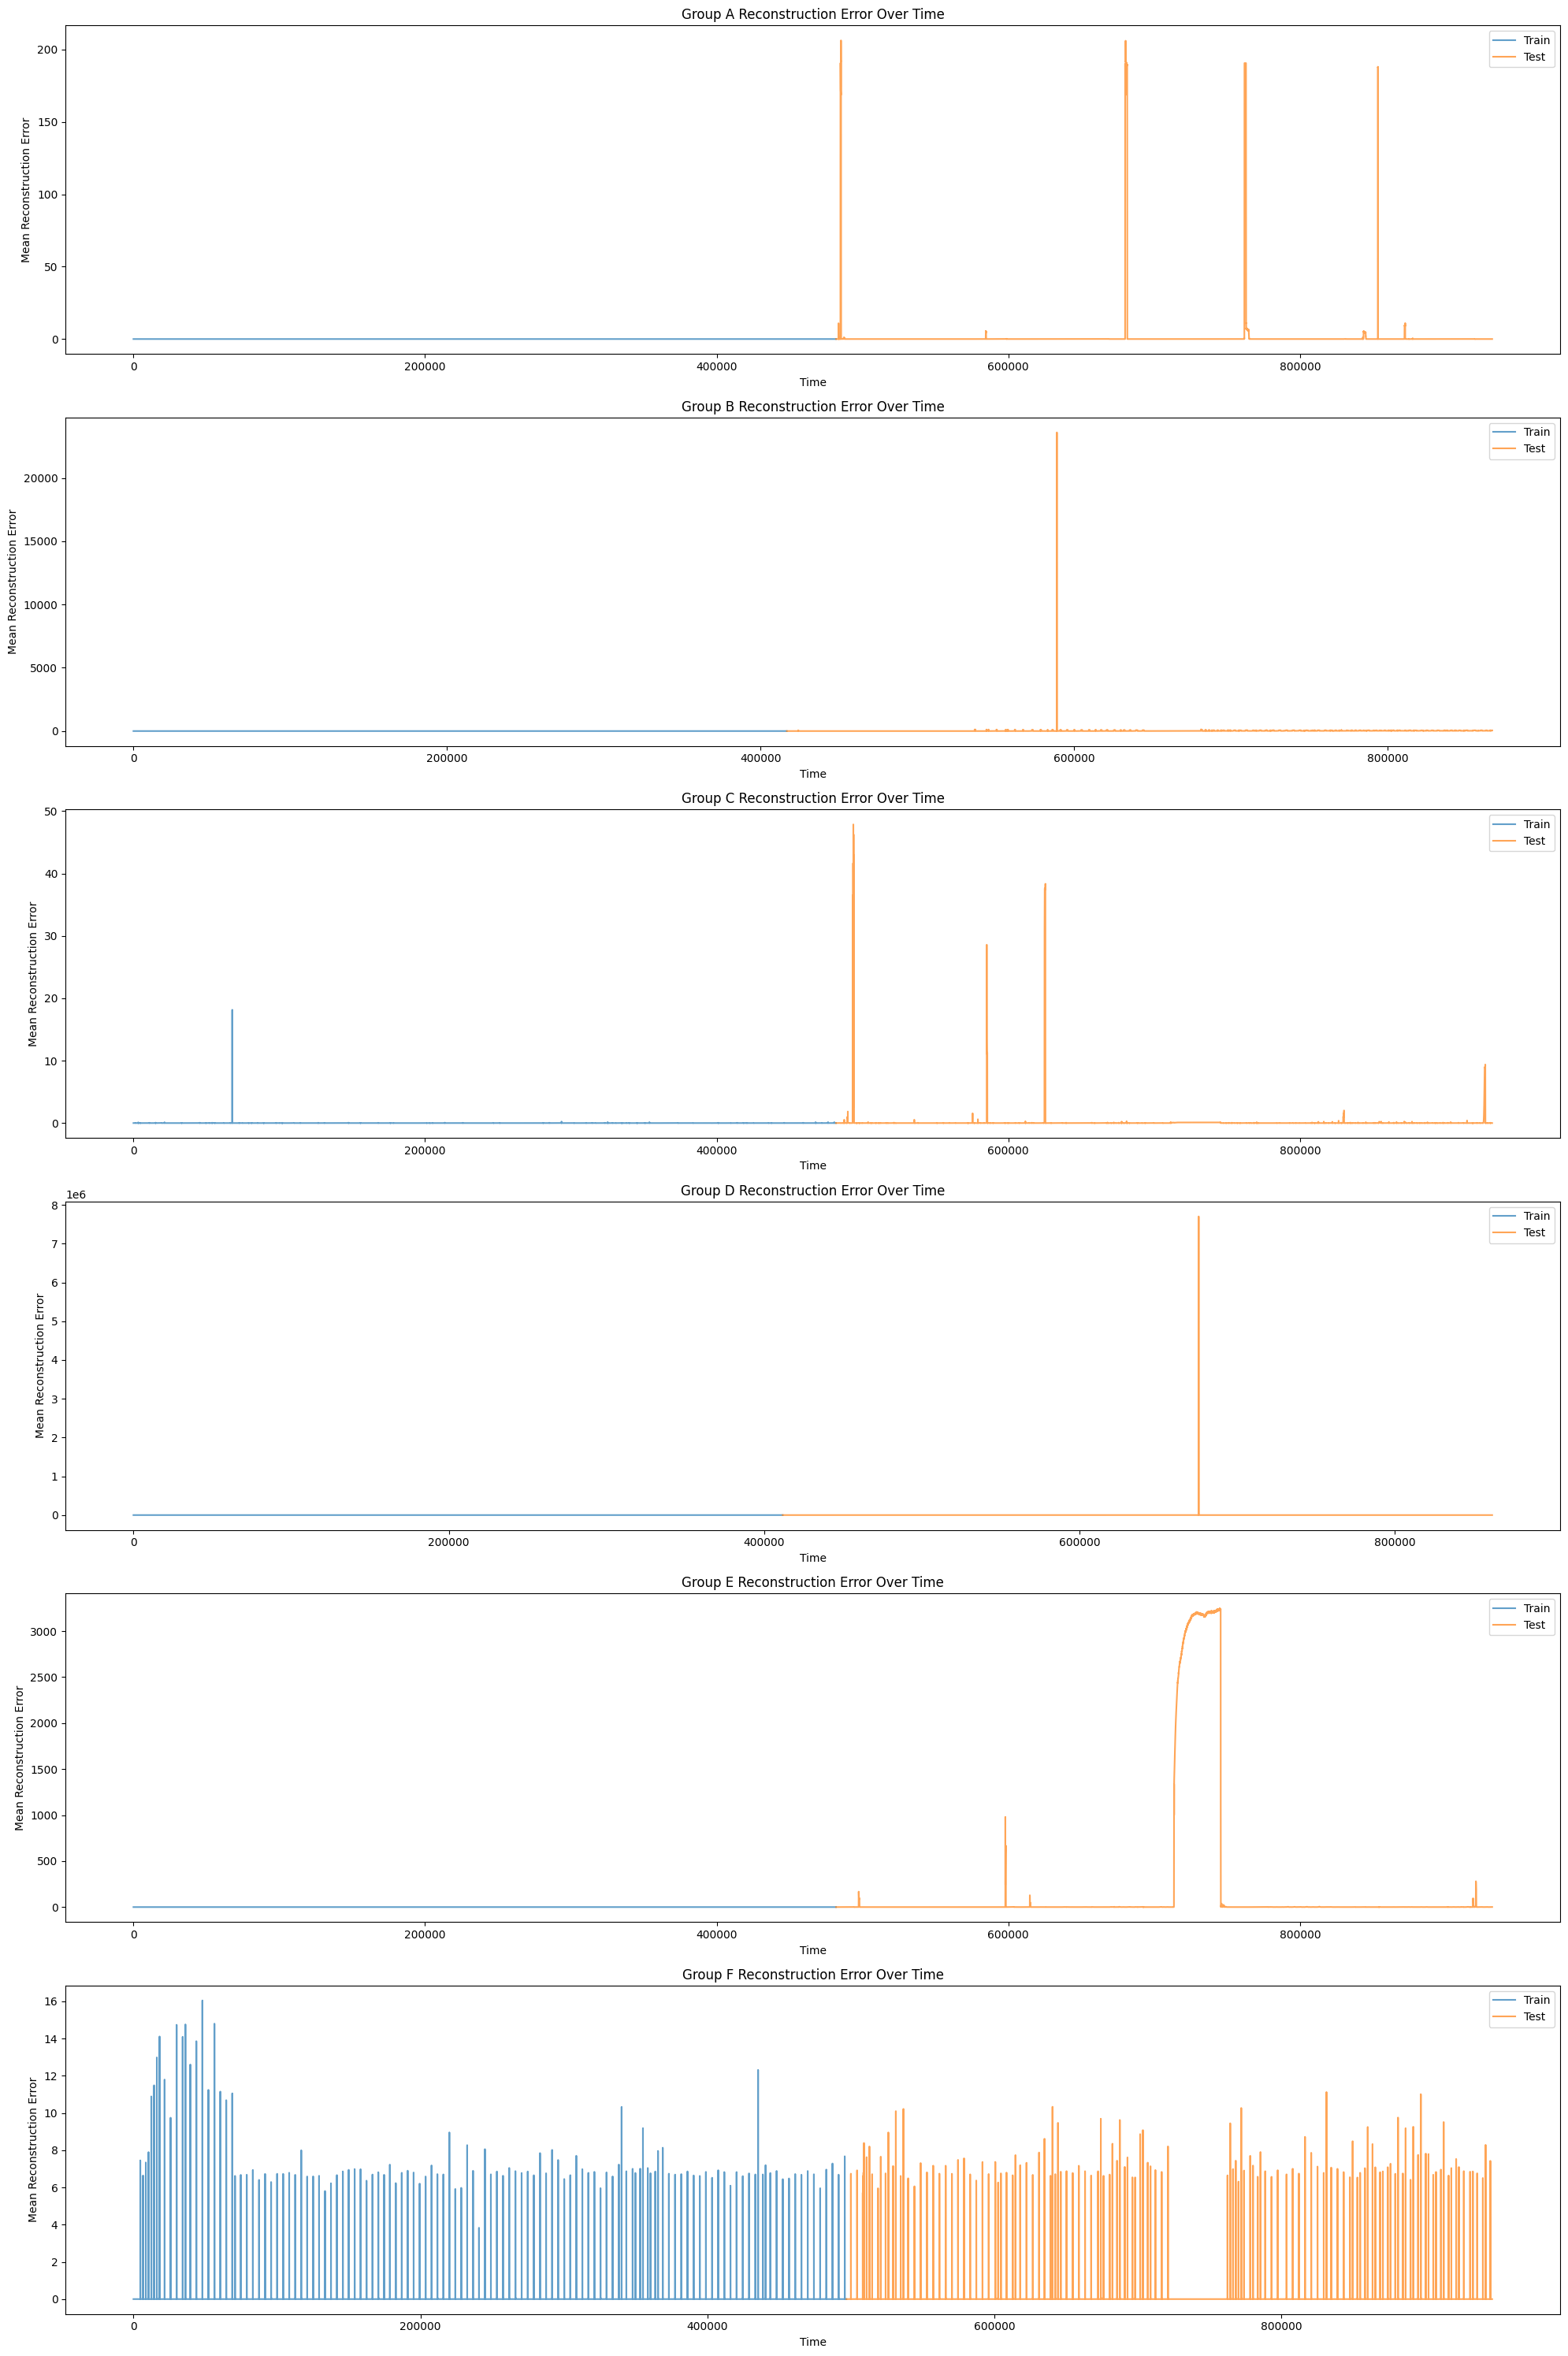

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def calculate_reconstruction_error(model, data):
    predictions = model.predict(data)
    mse = np.mean(np.square(data - predictions), axis=2)
    return mse

plt.figure(figsize=(20, 30))

for idx, group in enumerate(feature_groups.keys(), 1):
    # 모델 로드
    model = tf.keras.models.load_model(f'complex_autoencoder_model_{group}.h5')

    # Train 데이터 가져오기 및 Reconstruction Error 계산
    train_data = globals()[f'TRAIN_WINDOWS_{group}']
    train_error = calculate_reconstruction_error(model, train_data)

    # Test 데이터 가져오기 및 Reconstruction Error 계산
    test_data = globals()[f'TEST_WINDOWS_{group}']
    test_error = calculate_reconstruction_error(model, test_data)

    # 시간 축 생성 (윈도우의 중앙 시점을 기준으로)
    window_size = train_data.shape[1]
    train_time = np.arange(len(train_error)) + window_size // 2
    test_time = np.arange(len(test_error)) + len(train_error) + window_size // 2

    # 그래프 그리기
    plt.subplot(6, 1, idx)
    plt.plot(train_time, np.mean(train_error, axis=1), label='Train', alpha=0.7)
    plt.plot(test_time, np.mean(test_error, axis=1), label='Test', alpha=0.7)
    plt.title(f'Group {group} Reconstruction Error Over Time')
    plt.xlabel('Time')
    plt.ylabel('Mean Reconstruction Error')
    plt.legend()

    # 통계 출력
    print(f"Group {group}:")
    print(f"Train Error - Mean: {np.mean(train_error):.4f}, Std: {np.std(train_error):.4f}")
    print(f"Test Error  - Mean: {np.mean(test_error):.4f}, Std: {np.std(test_error):.4f}")
    print("=" * 50)

plt.tight_layout()
plt.show()

14062/14062 [==============================] - 26s 2ms/step


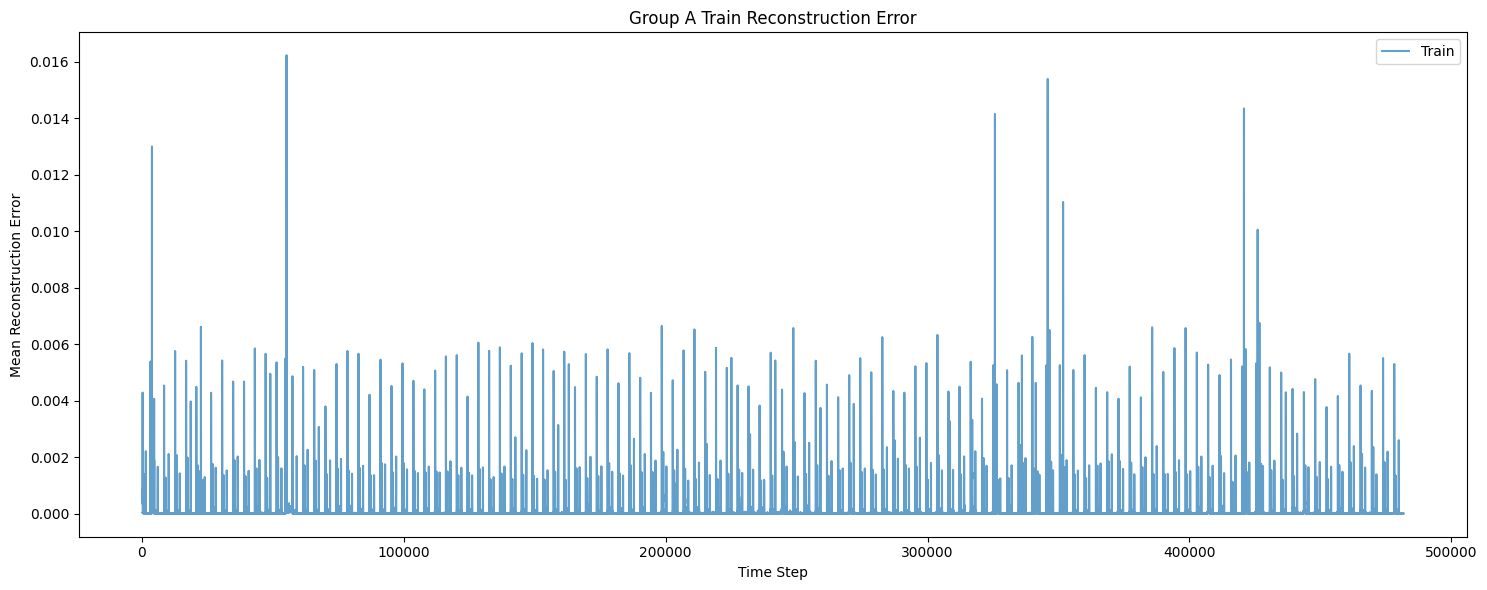

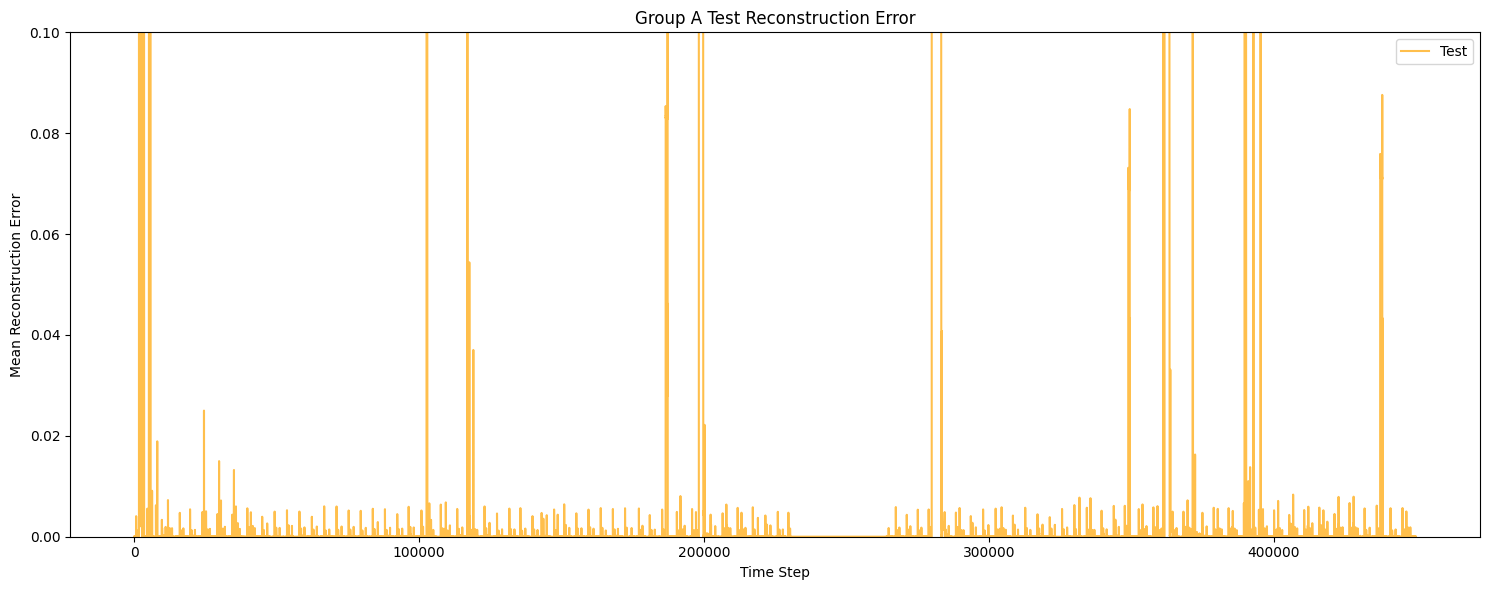

Group A:
Train Error - Mean: 0.0000, Std: 0.0005
Test Error  - Mean: 1.3617, Std: 15.5699


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def calculate_reconstruction_error(model, data):
    predictions = model.predict(data)
    mse = np.mean(np.square(data - predictions), axis=2)
    return mse

# A 그룹 모델 로드
model_A = tf.keras.models.load_model('complex_autoencoder_model_A.h5')

# Train 데이터 가져오기 및 Reconstruction Error 계산
train_data_A = TRAIN_WINDOWS_A
train_error_A = calculate_reconstruction_error(model_A, train_data_A)

# Test 데이터 가져오기 및 Reconstruction Error 계산
test_data_A = TEST_WINDOWS_A
test_error_A = calculate_reconstruction_error(model_A, test_data_A)

# Train 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(train_error_A, axis=1), label='Train', alpha=0.7)
plt.title('Group A Train Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.show()

# Test 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(test_error_A, axis=1), label='Test', alpha=0.7, color='orange')
plt.title('Group A Test Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.ylim(0,0.1)
plt.tight_layout()
plt.show()

# 통계 출력
print("Group A:")
print(f"Train Error - Mean: {np.mean(train_error_A):.4f}, Std: {np.std(train_error_A):.4f}")
print(f"Test Error  - Mean: {np.mean(test_error_A):.4f}, Std: {np.std(test_error_A):.4f}")

14062/14062 [==============================] - 27s 2ms/step


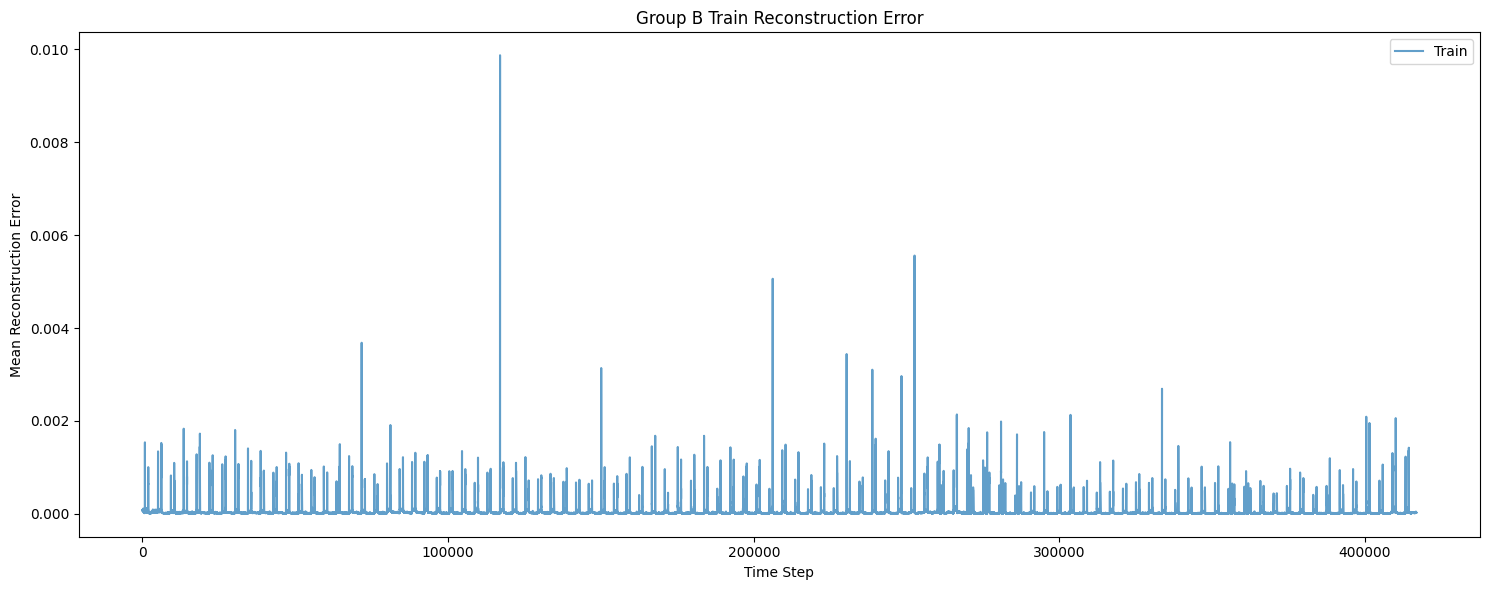

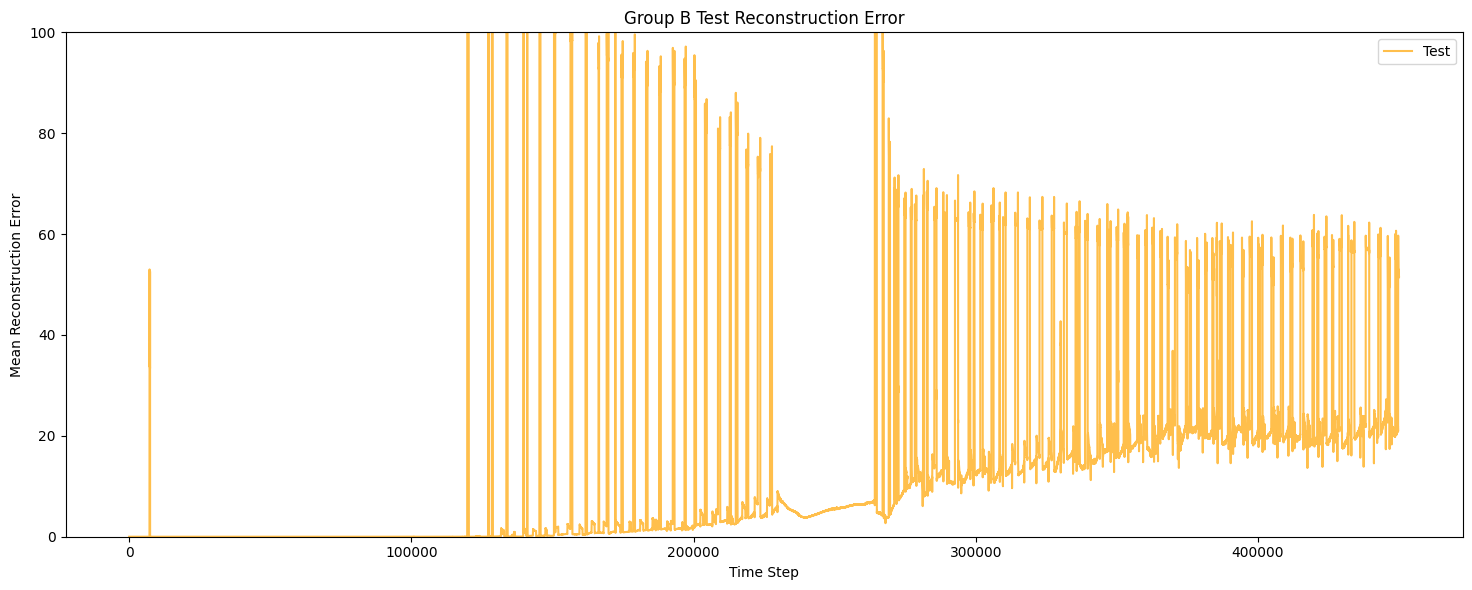

Group B:
Train Error - Mean: 0.0000, Std: 0.0002
Test Error  - Mean: 17.3692, Std: 261.2131


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def calculate_reconstruction_error(model, data):
    predictions = model.predict(data)
    mse = np.mean(np.square(data - predictions), axis=2)
    return mse

# B 그룹 모델 로드
model_B = tf.keras.models.load_model('complex_autoencoder_model_B.h5')

# Train 데이터 가져오기 및 Reconstruction Error 계산
train_data_B = TRAIN_WINDOWS_B
train_error_B = calculate_reconstruction_error(model_B, train_data_B)

# Test 데이터 가져오기 및 Reconstruction Error 계산
test_data_B = TEST_WINDOWS_B
test_error_B = calculate_reconstruction_error(model_B, test_data_B)

# Train 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(train_error_B, axis=1), label='Train', alpha=0.7)
plt.title('Group B Train Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.show()

# Test 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(test_error_B, axis=1), label='Test', alpha=0.7, color='orange')
plt.title('Group B Test Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.ylim(0,100)
plt.show()

# 통계 출력
print("Group B:")
print(f"Train Error - Mean: {np.mean(train_error_B):.4f}, Std: {np.std(train_error_B):.4f}")
print(f"Test Error  - Mean: {np.mean(test_error_B):.4f}, Std: {np.std(test_error_B):.4f}")

14062/14062 [==============================] - 27s 2ms/step


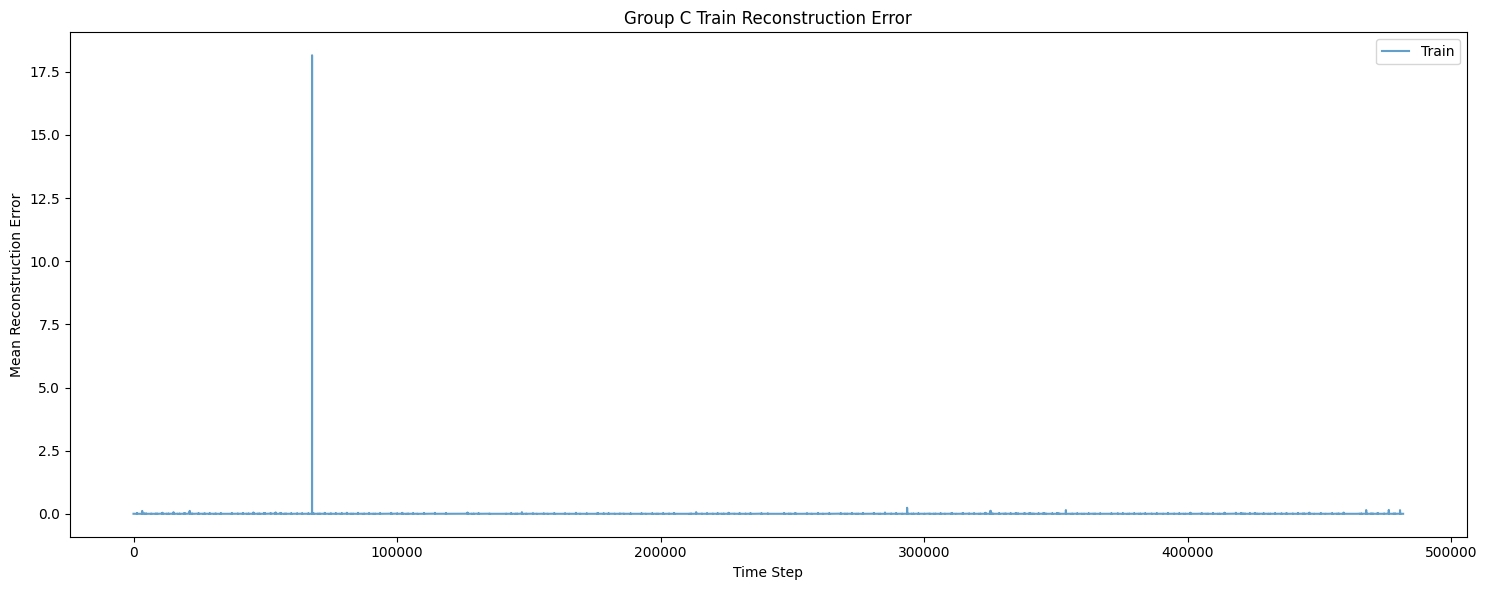

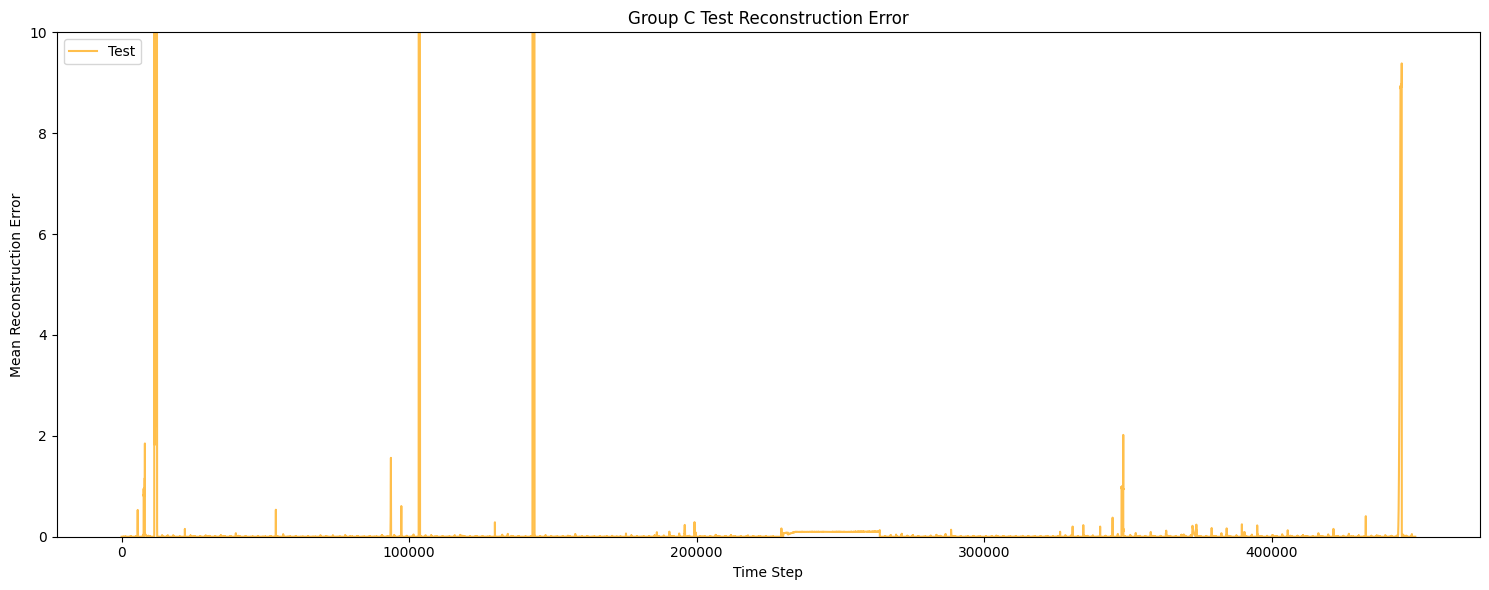

Group C:
Train Error - Mean: 0.0008, Std: 0.1289
Test Error  - Mean: 0.1482, Std: 2.0975


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def calculate_reconstruction_error(model, data):
    predictions = model.predict(data)
    mse = np.mean(np.square(data - predictions), axis=2)
    return mse

# C 그룹 모델 로드
model_C = tf.keras.models.load_model('complex_autoencoder_model_C.h5')

# Train 데이터 가져오기 및 Reconstruction Error 계산
train_data_C = TRAIN_WINDOWS_C
train_error_C = calculate_reconstruction_error(model_C, train_data_C)

# Test 데이터 가져오기 및 Reconstruction Error 계산
test_data_C = TEST_WINDOWS_C
test_error_C = calculate_reconstruction_error(model_C, test_data_C)

# Train 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(train_error_C, axis=1), label='Train', alpha=0.7)
plt.title('Group C Train Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.show()

# Test 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(test_error_C, axis=1), label='Test', alpha=0.7, color='orange')
plt.title('Group C Test Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.ylim(0,10)
plt.show()

# 통계 출력
print("Group C:")
print(f"Train Error - Mean: {np.mean(train_error_C):.4f}, Std: {np.std(train_error_C):.4f}")
print(f"Test Error  - Mean: {np.mean(test_error_C):.4f}, Std: {np.std(test_error_C):.4f}")

14062/14062 [==============================] - 27s 2ms/step


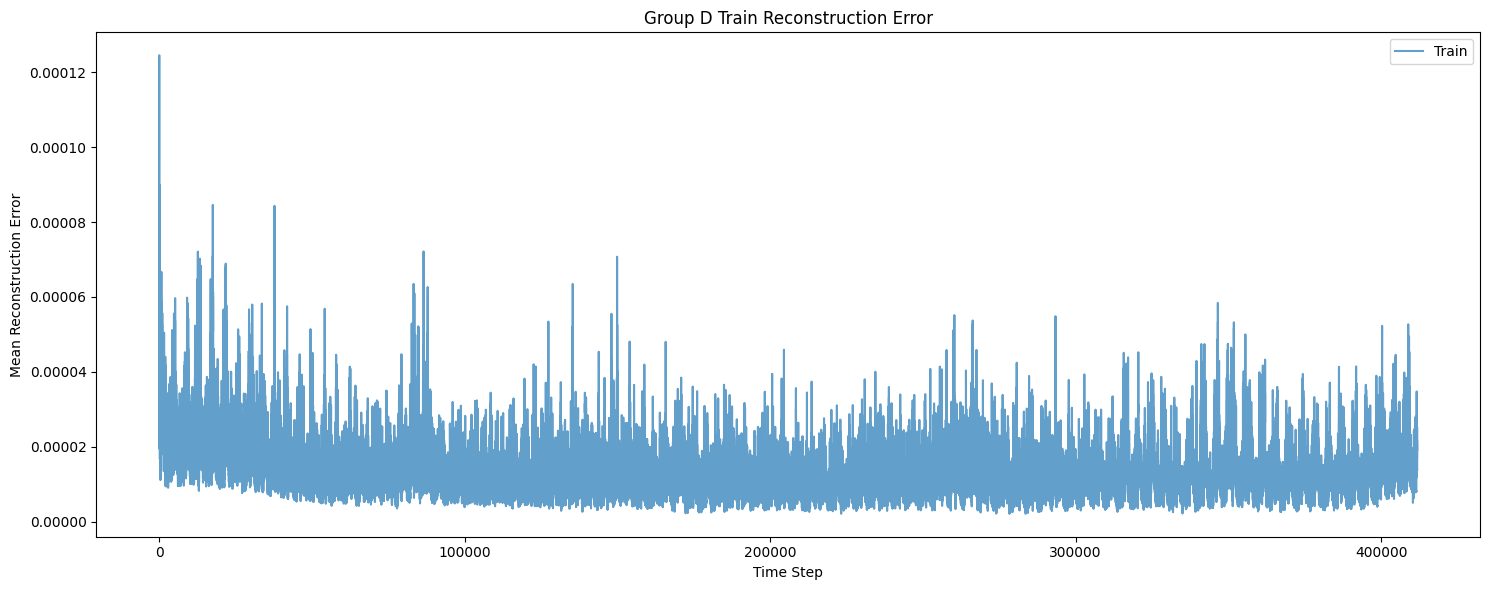

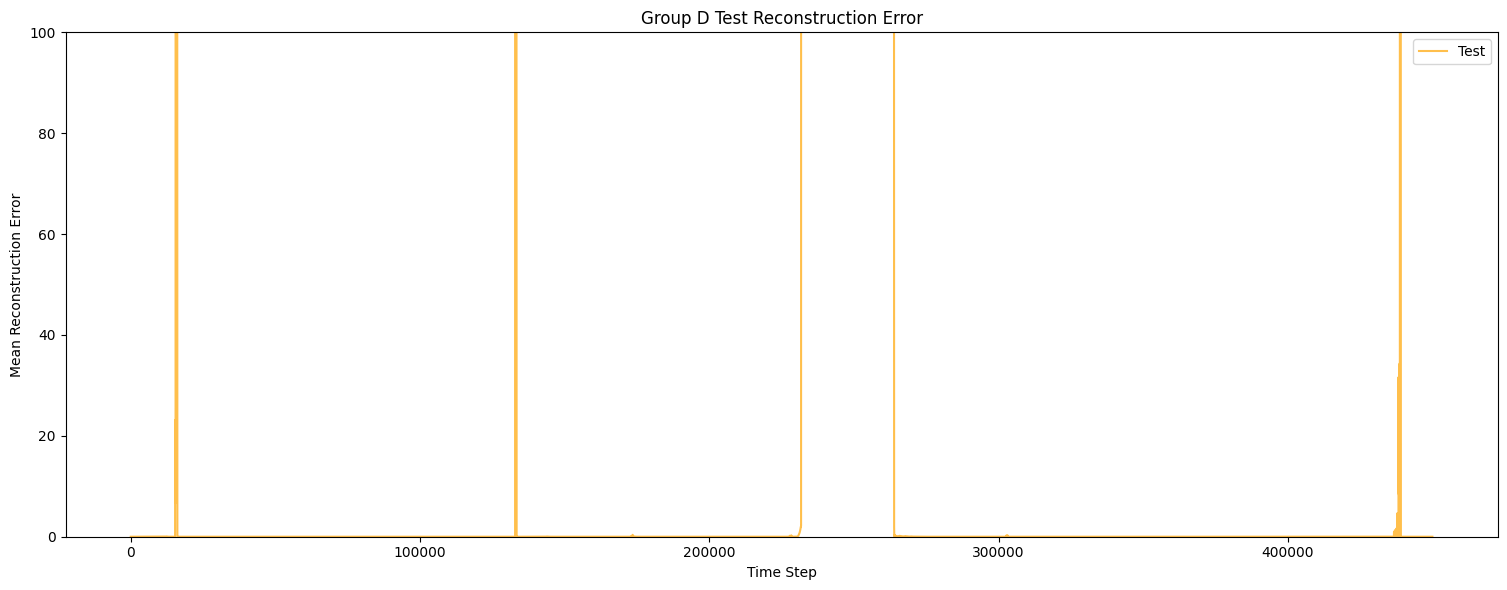

Group D:
Train Error - Mean: 0.0000, Std: 0.0000
Test Error  - Mean: 1084.2997, Std: 89367.0843


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def calculate_reconstruction_error(model, data):
    predictions = model.predict(data)
    mse = np.mean(np.square(data - predictions), axis=2)
    return mse

# D 그룹 모델 로드
model_D = tf.keras.models.load_model('complex_autoencoder_model_D.h5')

# Train 데이터 가져오기 및 Reconstruction Error 계산
train_data_D = TRAIN_WINDOWS_D
train_error_D = calculate_reconstruction_error(model_D, train_data_D)

# Test 데이터 가져오기 및 Reconstruction Error 계산
test_data_D = TEST_WINDOWS_D
test_error_D = calculate_reconstruction_error(model_D, test_data_D)

# Train 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(train_error_D, axis=1), label='Train', alpha=0.7)
plt.title('Group D Train Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.show()

# Test 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(test_error_D, axis=1), label='Test', alpha=0.7, color='orange')
plt.title('Group D Test Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.ylim(0,100)
plt.show()

# 통계 출력
print("Group D:")
print(f"Train Error - Mean: {np.mean(train_error_D):.4f}, Std: {np.std(train_error_D):.4f}")
print(f"Test Error  - Mean: {np.mean(test_error_D):.4f}, Std: {np.std(test_error_D):.4f}")

14062/14062 [==============================] - 27s 2ms/step


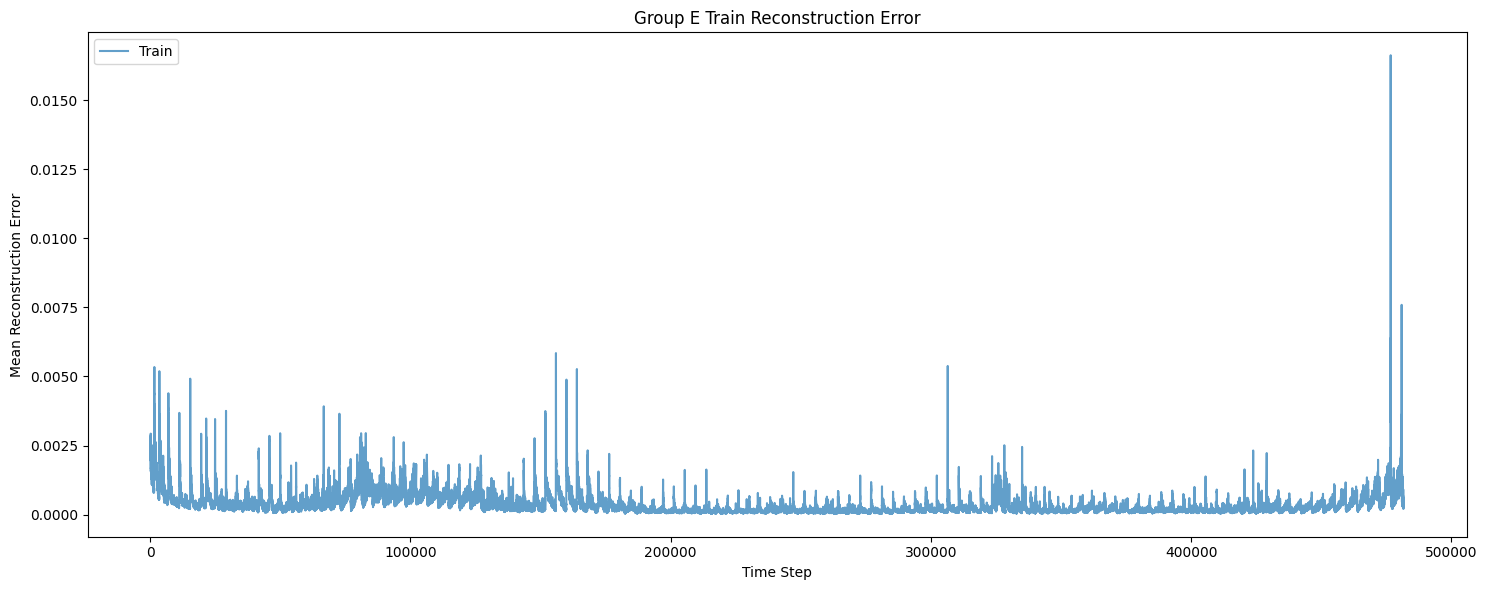

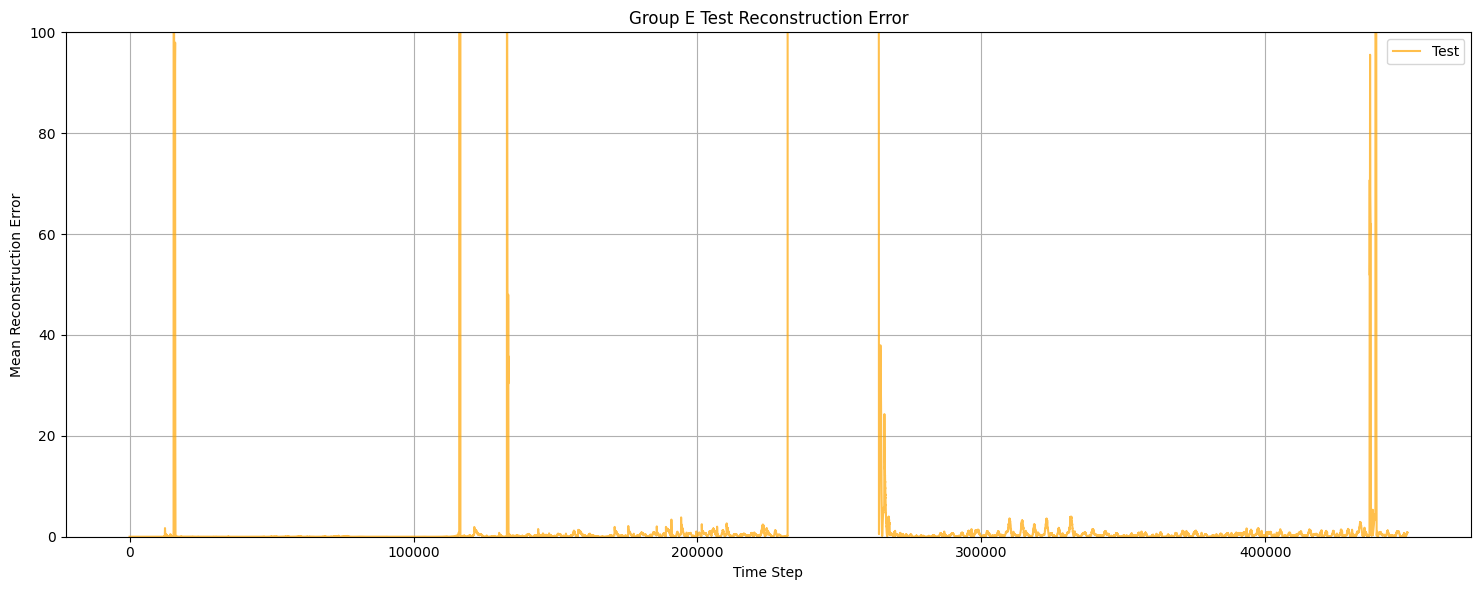

Group E:
Train Error - Mean: 0.0003, Std: 0.0005
Test Error  - Mean: 215.7970, Std: 793.0487


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def calculate_reconstruction_error(model, data):
    predictions = model.predict(data)
    mse = np.mean(np.square(data - predictions), axis=2)
    return mse

# E 그룹 모델 로드
model_E = tf.keras.models.load_model('complex_autoencoder_model_E.h5')

# Train 데이터 가져오기 및 Reconstruction Error 계산
train_data_E = TRAIN_WINDOWS_E
train_error_E = calculate_reconstruction_error(model_E, train_data_E)

# Test 데이터 가져오기 및 Reconstruction Error 계산
test_data_E = TEST_WINDOWS_E
test_error_E = calculate_reconstruction_error(model_E, test_data_E)

# Train 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(train_error_E, axis=1), label='Train', alpha=0.7)
plt.title('Group E Train Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.show()

# Test 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(test_error_E, axis=1), label='Test', alpha=0.7, color='orange')
plt.title('Group E Test Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.ylim(0,100)
plt.grid(True)
plt.show()

# 통계 출력
print("Group E:")
print(f"Train Error - Mean: {np.mean(train_error_E):.4f}, Std: {np.std(train_error_E):.4f}")
print(f"Test Error  - Mean: {np.mean(test_error_E):.4f}, Std: {np.std(test_error_E):.4f}")

14062/14062 [==============================] - 26s 2ms/step


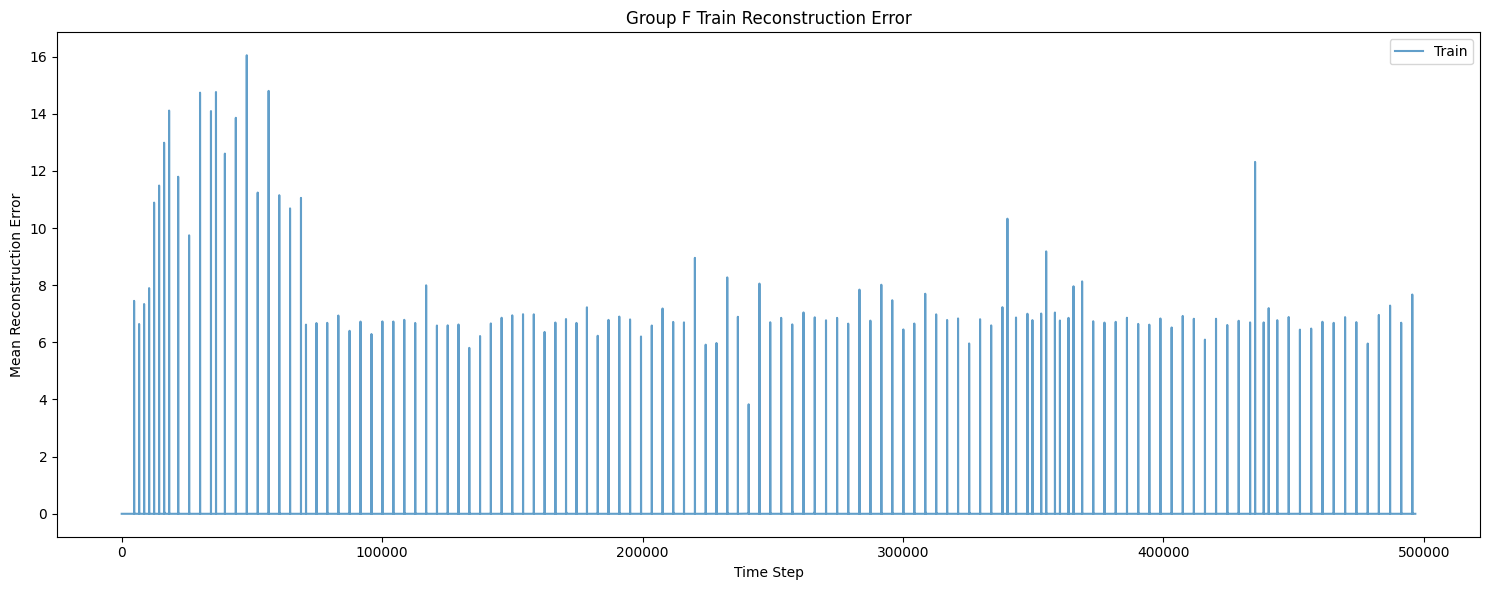

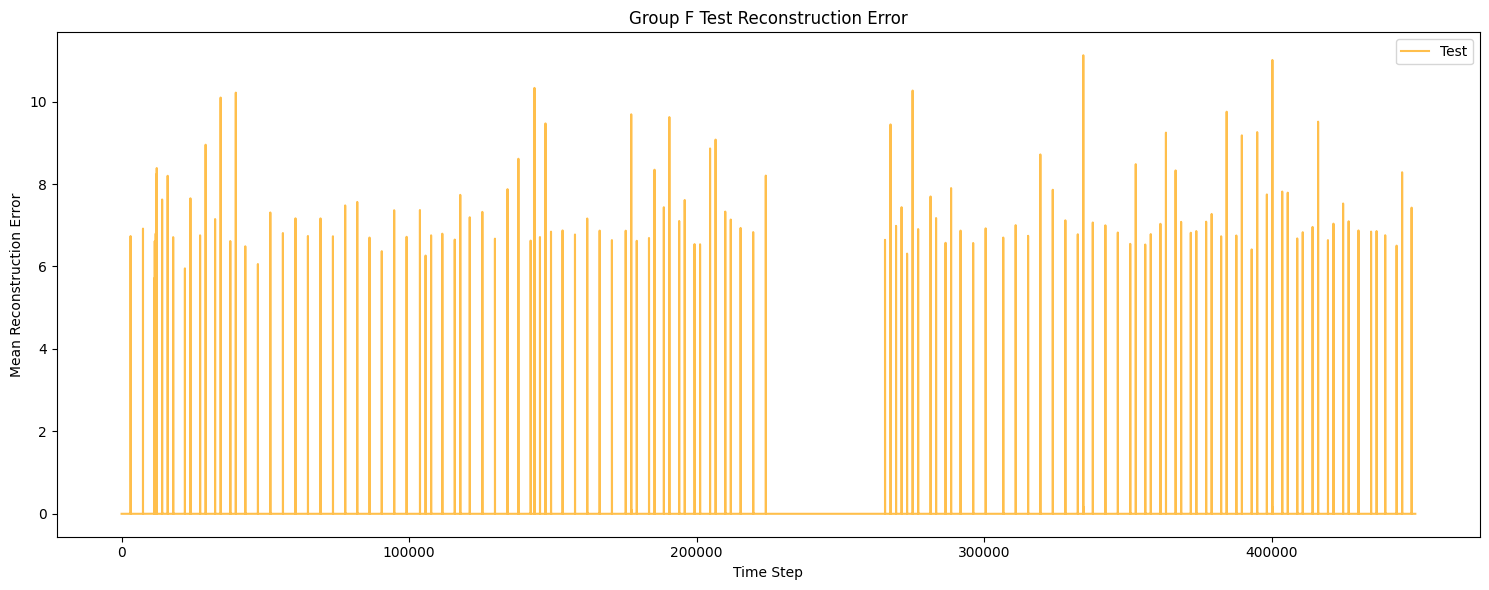

Group F:
Train Error - Mean: 0.0022, Std: 0.3469
Test Error  - Mean: 0.0028, Std: 0.3713


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def calculate_reconstruction_error(model, data):
    predictions = model.predict(data)
    mse = np.mean(np.square(data - predictions), axis=2)
    return mse

# F 그룹 모델 로드
model_F = tf.keras.models.load_model('complex_autoencoder_model_F.h5')

# Train 데이터 가져오기 및 Reconstruction Error 계산
train_data_F = TRAIN_WINDOWS_F
train_error_F = calculate_reconstruction_error(model_F, train_data_F)

# Test 데이터 가져오기 및 Reconstruction Error 계산
test_data_F = TEST_WINDOWS_F
test_error_F = calculate_reconstruction_error(model_F, test_data_F)

# Train 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(train_error_F, axis=1), label='Train', alpha=0.7)
plt.title('Group F Train Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.show()

# Test 데이터 그래프
plt.figure(figsize=(15, 6))
plt.plot(np.mean(test_error_F, axis=1), label='Test', alpha=0.7, color='orange')
plt.title('Group F Test Reconstruction Error')
plt.xlabel('Time Step')
plt.ylabel('Mean Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.show()

# 통계 출력
print("Group F:")
print(f"Train Error - Mean: {np.mean(train_error_F):.4f}, Std: {np.std(train_error_F):.4f}")
print(f"Test Error  - Mean: {np.mean(test_error_F):.4f}, Std: {np.std(test_error_F):.4f}")

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# 원본 TEST 데이터 로드
TEST_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/test/test.csv")

# Window 크기 설정
WINDOW_SIZE = window_size  # 예시 값, 실제 사용한 window size로 변경해야 합니다.

def calculate_reconstruction_error(model, data):
    predictions = model.predict(data)
    mse = np.mean(np.square(data - predictions), axis=2)
    return mse

# 각 그룹에 대한 모델 로드 및 reconstruction error 계산
groups = ['A', 'B', 'C', 'D', 'E', 'F']
test_mse = {}
thresholds = {'A': 10, 'B': 1000, 'C': 20, 'D': 100, 'E': 500, 'F': 100}  # 주어진 threshold 값

for group in groups:
    model = tf.keras.models.load_model(f'complex_autoencoder_model_{group}.h5')
    test_data = globals()[f'TEST_WINDOWS_{group}']
    test_mse[group] = calculate_reconstruction_error(model, test_data)

# Anomaly 판단 (직접 threshold와 비교)
anomaly_mask = np.zeros(len(test_mse['A']), dtype=bool)
for group in groups:
    anomaly_mask |= np.any(test_mse[group] >= thresholds[group], axis=1)

# 제출용 데이터프레임 초기화 (모든 값을 0으로 설정)
submission_df = pd.DataFrame({
    'Timestamp': TEST_DF_RAW['Timestamp'],
    'anomaly': 0
})

# WINDOW_SIZE - 1만큼의 앞부분은 0으로 유지하고, 그 이후부터 모델의 예측 결과 적용
submission_df.loc[WINDOW_SIZE-1:, 'anomaly'] = np.where(anomaly_mask, 1, 0)

# CSV 파일로 저장
submission_df.to_csv('sample_submission.csv', index=False)

print("제출 파일이 생성되었습니다: sample_submission.csv")

# 결과 요약
anomaly_count = np.sum(submission_df['anomaly'])
print(f"\n총 데이터 포인트 수: {len(TEST_DF_RAW)}")
print(f"이상 탐지된 데이터 포인트 수: {anomaly_count}")
print(f"정상으로 판단된 데이터 포인트 수: {len(TEST_DF_RAW) - anomaly_count}")

# 각 그룹별 anomaly 비율 출력
print("\n각 그룹별 anomaly 비율:")
for group in groups:
    group_anomaly = np.any(test_mse[group] >= thresholds[group], axis=1)
    group_anomaly_ratio = np.mean(group_anomaly) * 100
    print(f"Group {group}: {group_anomaly_ratio:.2f}%")

14062/14062 [==============================] - 27s 2ms/step
제출 파일이 생성되었습니다: sample_submission.csv

총 데이터 포인트 수: 450000
이상 탐지된 데이터 포인트 수: 40564
정상으로 판단된 데이터 포인트 수: 409436

각 그룹별 anomaly 비율:
Group A: 0.92%
Group B: 0.02%
Group C: 0.36%
Group D: 7.59%
Group E: 7.49%
Group F: 0.02%
